# Installing Dependencies

In [2]:
!pip install git+https://github.com/m-bain/whisperX.git@78dcfaab51005aa703ee21375f81ed31bc248560
!pip install --no-build-isolation nemo_toolkit[asr]==1.23.0
!pip install --no-deps git+https://github.com/facebookresearch/demucs#egg=demucs
!pip install git+https://github.com/oliverguhr/deepmultilingualpunctuation.git
!pip install git+https://github.com/MahmoudAshraf97/ctc-forced-aligner.git
!pip install -qq pyannote.audio==3.1.1

  Cloning https://github.com/m-bain/whisperX.git (to revision 78dcfaab51005aa703ee21375f81ed31bc248560) to /tmp/pip-req-build-okyuozg6
  Running command git clone --filter=blob:none --quiet https://github.com/m-bain/whisperX.git /tmp/pip-req-build-okyuozg6
  Running command git rev-parse -q --verify 'sha^78dcfaab51005aa703ee21375f81ed31bc248560'
  Running command git fetch -q https://github.com/m-bain/whisperX.git 78dcfaab51005aa703ee21375f81ed31bc248560
  Running command git checkout -q 78dcfaab51005aa703ee21375f81ed31bc248560
  Resolved https://github.com/m-bain/whisperX.git to commit 78dcfaab51005aa703ee21375f81ed31bc248560
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/demucs to /tmp/pip-install-y5sr8hgl/demucs_073775df6db146c7afa666c7958cb526
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/demucs /tmp/pip-install-y5sr8hgl/demucs_073775df6db146c7afa666c7958cb526
  Resolved https://github.com/facebook

In [3]:
import os
import wget
from omegaconf import OmegaConf
import json
import shutil
import torch
import torchaudio
from nemo.collections.asr.models.msdd_models import NeuralDiarizer
from deepmultilingualpunctuation import PunctuationModel
import re
import logging
import nltk
from whisperx.utils import LANGUAGES, TO_LANGUAGE_CODE
from ctc_forced_aligner import (
    load_alignment_model,
    generate_emissions,
    preprocess_text,
    get_alignments,
    get_spans,
    postprocess_results,
)

[NeMo W 2024-06-04 17:01:57 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
      torchaudio.set_audio_backend("soundfile")
    


# Helper Functions

In [4]:
punct_model_langs = [
    "en",
    "fr",
    "de",
    "es",
    "it",
    "nl",
    "pt",
    "bg",
    "pl",
    "cs",
    "sk",
    "sl",
]
langs_to_iso = {
    "af": "afr",
    "am": "amh",
    "ar": "ara",
    "as": "asm",
    "az": "aze",
    "ba": "bak",
    "be": "bel",
    "bg": "bul",
    "bn": "ben",
    "bo": "tib",
    "br": "bre",
    "bs": "bos",
    "ca": "cat",
    "cs": "cze",
    "cy": "wel",
    "da": "dan",
    "de": "ger",
    "el": "gre",
    "en": "eng",
    "es": "spa",
    "et": "est",
    "eu": "baq",
    "fa": "per",
    "fi": "fin",
    "fo": "fao",
    "fr": "fre",
    "gl": "glg",
    "gu": "guj",
    "ha": "hau",
    "haw": "haw",
    "he": "heb",
    "hi": "hin",
    "hr": "hrv",
    "ht": "hat",
    "hu": "hun",
    "hy": "arm",
    "id": "ind",
    "is": "ice",
    "it": "ita",
    "ja": "jpn",
    "jw": "jav",
    "ka": "geo",
    "kk": "kaz",
    "km": "khm",
    "kn": "kan",
    "ko": "kor",
    "la": "lat",
    "lb": "ltz",
    "ln": "lin",
    "lo": "lao",
    "lt": "lit",
    "lv": "lav",
    "mg": "mlg",
    "mi": "mao",
    "mk": "mac",
    "ml": "mal",
    "mn": "mon",
    "mr": "mar",
    "ms": "may",
    "mt": "mlt",
    "my": "bur",
    "ne": "nep",
    "nl": "dut",
    "nn": "nno",
    "no": "nor",
    "oc": "oci",
    "pa": "pan",
    "pl": "pol",
    "ps": "pus",
    "pt": "por",
    "ro": "rum",
    "ru": "rus",
    "sa": "san",
    "sd": "snd",
    "si": "sin",
    "sk": "slo",
    "sl": "slv",
    "sn": "sna",
    "so": "som",
    "sq": "alb",
    "sr": "srp",
    "su": "sun",
    "sv": "swe",
    "sw": "swa",
    "ta": "tam",
    "te": "tel",
    "tg": "tgk",
    "th": "tha",
    "tk": "tuk",
    "tl": "tgl",
    "tr": "tur",
    "tt": "tat",
    "uk": "ukr",
    "ur": "urd",
    "uz": "uzb",
    "vi": "vie",
    "yi": "yid",
    "yo": "yor",
    "yue": "yue",
    "zh": "chi",
}


whisper_langs = sorted(LANGUAGES.keys()) + sorted(
    [k.title() for k in TO_LANGUAGE_CODE.keys()]
)


def create_config(output_dir):
    DOMAIN_TYPE = "telephonic"  # Can be meeting, telephonic, or general based on domain type of the audio file
    CONFIG_FILE_NAME = f"diar_infer_{DOMAIN_TYPE}.yaml"
    CONFIG_URL = f"https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/inference/{CONFIG_FILE_NAME}"
    MODEL_CONFIG = os.path.join(output_dir, CONFIG_FILE_NAME)
    if not os.path.exists(MODEL_CONFIG):
        MODEL_CONFIG = wget.download(CONFIG_URL, output_dir)

    config = OmegaConf.load(MODEL_CONFIG)

    data_dir = os.path.join(output_dir, "data")
    os.makedirs(data_dir, exist_ok=True)

    meta = {
        "audio_filepath": os.path.join(output_dir, "mono_file.wav"),
        "offset": 0,
        "duration": None,
        "label": "infer",
        "text": "-",
        "rttm_filepath": None,
        "uem_filepath": None,
    }
    with open(os.path.join(data_dir, "input_manifest.json"), "w") as fp:
        json.dump(meta, fp)
        fp.write("\n")

    pretrained_vad = "vad_multilingual_marblenet"
    pretrained_speaker_model = "titanet_large"
    config.num_workers = 0  # Workaround for multiprocessing hanging with ipython issue
    config.diarizer.manifest_filepath = os.path.join(data_dir, "input_manifest.json")
    config.diarizer.out_dir = (
        output_dir  # Directory to store intermediate files and prediction outputs
    )

    config.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
    config.diarizer.oracle_vad = (
        False  # compute VAD provided with model_path to vad config
    )
    config.diarizer.clustering.parameters.oracle_num_speakers = False

    # Here, we use our in-house pretrained NeMo VAD model
    config.diarizer.vad.model_path = pretrained_vad
    config.diarizer.vad.parameters.onset = 0.8
    config.diarizer.vad.parameters.offset = 0.6
    config.diarizer.vad.parameters.pad_offset = -0.05
    config.diarizer.msdd_model.model_path = (
        "diar_msdd_telephonic"  # Telephonic speaker diarization model
    )

    return config


def get_word_ts_anchor(s, e, option="start"):
    if option == "end":
        return e
    elif option == "mid":
        return (s + e) / 2
    return s


def get_words_speaker_mapping(wrd_ts, spk_ts, word_anchor_option="start"):
    s, e, sp = spk_ts[0]
    wrd_pos, turn_idx = 0, 0
    wrd_spk_mapping = []
    for wrd_dict in wrd_ts:
        ws, we, wrd = (
            int(wrd_dict["start"] * 1000),
            int(wrd_dict["end"] * 1000),
            wrd_dict["text"],
        )
        wrd_pos = get_word_ts_anchor(ws, we, word_anchor_option)
        while wrd_pos > float(e):
            turn_idx += 1
            turn_idx = min(turn_idx, len(spk_ts) - 1)
            s, e, sp = spk_ts[turn_idx]
            if turn_idx == len(spk_ts) - 1:
                e = get_word_ts_anchor(ws, we, option="end")
        wrd_spk_mapping.append(
            {"word": wrd, "start_time": ws, "end_time": we, "speaker": sp}
        )
    return wrd_spk_mapping


sentence_ending_punctuations = ".?!"


def get_first_word_idx_of_sentence(word_idx, word_list, speaker_list, max_words):
    is_word_sentence_end = (
        lambda x: x >= 0 and word_list[x][-1] in sentence_ending_punctuations
    )
    left_idx = word_idx
    while (
        left_idx > 0
        and word_idx - left_idx < max_words
        and speaker_list[left_idx - 1] == speaker_list[left_idx]
        and not is_word_sentence_end(left_idx - 1)
    ):
        left_idx -= 1

    return left_idx if left_idx == 0 or is_word_sentence_end(left_idx - 1) else -1


def get_last_word_idx_of_sentence(word_idx, word_list, max_words):
    is_word_sentence_end = (
        lambda x: x >= 0 and word_list[x][-1] in sentence_ending_punctuations
    )
    right_idx = word_idx
    while (
        right_idx < len(word_list) - 1
        and right_idx - word_idx < max_words
        and not is_word_sentence_end(right_idx)
    ):
        right_idx += 1

    return (
        right_idx
        if right_idx == len(word_list) - 1 or is_word_sentence_end(right_idx)
        else -1
    )


def get_realigned_ws_mapping_with_punctuation(
    word_speaker_mapping, max_words_in_sentence=50
):
    is_word_sentence_end = (
        lambda x: x >= 0
        and word_speaker_mapping[x]["word"][-1] in sentence_ending_punctuations
    )
    wsp_len = len(word_speaker_mapping)

    words_list, speaker_list = [], []
    for k, line_dict in enumerate(word_speaker_mapping):
        word, speaker = line_dict["word"], line_dict["speaker"]
        words_list.append(word)
        speaker_list.append(speaker)

    k = 0
    while k < len(word_speaker_mapping):
        line_dict = word_speaker_mapping[k]
        if (
            k < wsp_len - 1
            and speaker_list[k] != speaker_list[k + 1]
            and not is_word_sentence_end(k)
        ):
            left_idx = get_first_word_idx_of_sentence(
                k, words_list, speaker_list, max_words_in_sentence
            )
            right_idx = (
                get_last_word_idx_of_sentence(
                    k, words_list, max_words_in_sentence - k + left_idx - 1
                )
                if left_idx > -1
                else -1
            )
            if min(left_idx, right_idx) == -1:
                k += 1
                continue

            spk_labels = speaker_list[left_idx : right_idx + 1]
            mod_speaker = max(set(spk_labels), key=spk_labels.count)
            if spk_labels.count(mod_speaker) < len(spk_labels) // 2:
                k += 1
                continue

            speaker_list[left_idx : right_idx + 1] = [mod_speaker] * (
                right_idx - left_idx + 1
            )
            k = right_idx

        k += 1

    k, realigned_list = 0, []
    while k < len(word_speaker_mapping):
        line_dict = word_speaker_mapping[k].copy()
        line_dict["speaker"] = speaker_list[k]
        realigned_list.append(line_dict)
        k += 1

    return realigned_list


def get_sentences_speaker_mapping(word_speaker_mapping, spk_ts):
    sentence_checker = nltk.tokenize.PunktSentenceTokenizer().text_contains_sentbreak
    s, e, spk = spk_ts[0]
    prev_spk = spk

    snts = []
    snt = {"speaker": f"Speaker {spk}", "start_time": s, "end_time": e, "text": ""}

    for wrd_dict in word_speaker_mapping:
        wrd, spk = wrd_dict["word"], wrd_dict["speaker"]
        s, e = wrd_dict["start_time"], wrd_dict["end_time"]
        if spk != prev_spk or sentence_checker(snt["text"] + " " + wrd):
            snts.append(snt)
            snt = {
                "speaker": f"Speaker {spk}",
                "start_time": s,
                "end_time": e,
                "text": "",
            }
        else:
            snt["end_time"] = e
        snt["text"] += wrd + " "
        prev_spk = spk

    snts.append(snt)
    return snts


def get_speaker_aware_transcript(sentences_speaker_mapping, f):
    previous_speaker = sentences_speaker_mapping[0]["speaker"]
    f.write(f"{previous_speaker}: ")

    for sentence_dict in sentences_speaker_mapping:
        speaker = sentence_dict["speaker"]
        sentence = sentence_dict["text"]

        # If this speaker doesn't match the previous one, start a new paragraph
        if speaker != previous_speaker:
            f.write(f"\n\n{speaker}: ")
            previous_speaker = speaker

        # No matter what, write the current sentence
        f.write(sentence + " ")


def format_timestamp(
    milliseconds: float, always_include_hours: bool = False, decimal_marker: str = "."
):
    assert milliseconds >= 0, "non-negative timestamp expected"

    hours = milliseconds // 3_600_000
    milliseconds -= hours * 3_600_000

    minutes = milliseconds // 60_000
    milliseconds -= minutes * 60_000

    seconds = milliseconds // 1_000
    milliseconds -= seconds * 1_000

    hours_marker = f"{hours:02d}:" if always_include_hours or hours > 0 else ""
    return (
        f"{hours_marker}{minutes:02d}:{seconds:02d}{decimal_marker}{milliseconds:03d}"
    )


def write_srt(transcript, file):
    """
    Write a transcript to a file in SRT format.

    """
    for i, segment in enumerate(transcript, start=1):
        # write srt lines
        print(
            f"{i}\n"
            f"{format_timestamp(segment['start_time'], always_include_hours=True, decimal_marker=',')} --> "
            f"{format_timestamp(segment['end_time'], always_include_hours=True, decimal_marker=',')}\n"
            f"{segment['speaker']}: {segment['text'].strip().replace('-->', '->')}\n",
            file=file,
            flush=True,
        )


def find_numeral_symbol_tokens(tokenizer):
    numeral_symbol_tokens = [
        -1,
    ]
    for token, token_id in tokenizer.get_vocab().items():
        has_numeral_symbol = any(c in "0123456789%$£" for c in token)
        if has_numeral_symbol:
            numeral_symbol_tokens.append(token_id)
    return numeral_symbol_tokens


def _get_next_start_timestamp(word_timestamps, current_word_index, final_timestamp):
    # if current word is the last word
    if current_word_index == len(word_timestamps) - 1:
        return word_timestamps[current_word_index]["start"]

    next_word_index = current_word_index + 1
    while current_word_index < len(word_timestamps) - 1:
        if word_timestamps[next_word_index].get("start") is None:
            # if next word doesn't have a start timestamp
            # merge it with the current word and delete it
            word_timestamps[current_word_index]["word"] += (
                " " + word_timestamps[next_word_index]["word"]
            )

            word_timestamps[next_word_index]["word"] = None
            next_word_index += 1
            if next_word_index == len(word_timestamps):
                return final_timestamp

        else:
            return word_timestamps[next_word_index]["start"]


def filter_missing_timestamps(
    word_timestamps, initial_timestamp=0, final_timestamp=None
):
    # handle the first and last word
    if word_timestamps[0].get("start") is None:
        word_timestamps[0]["start"] = (
            initial_timestamp if initial_timestamp is not None else 0
        )
        word_timestamps[0]["end"] = _get_next_start_timestamp(
            word_timestamps, 0, final_timestamp
        )

    result = [
        word_timestamps[0],
    ]

    for i, ws in enumerate(word_timestamps[1:], start=1):
        # if ws doesn't have a start and end
        # use the previous end as start and next start as end
        if ws.get("start") is None and ws.get("word") is not None:
            ws["start"] = word_timestamps[i - 1]["end"]
            ws["end"] = _get_next_start_timestamp(word_timestamps, i, final_timestamp)

        if ws["word"] is not None:
            result.append(ws)
    return result


def cleanup(path: str):
    """path could either be relative or absolute."""
    # check if file or directory exists
    if os.path.isfile(path) or os.path.islink(path):
        # remove file
        os.remove(path)
    elif os.path.isdir(path):
        # remove directory and all its content
        shutil.rmtree(path)
    else:
        raise ValueError("Path {} is not a file or dir.".format(path))


def process_language_arg(language: str, model_name: str):
    """
    Process the language argument to make sure it's valid and convert language names to language codes.
    """
    if language is not None:
        language = language.lower()
    if language not in LANGUAGES:
        if language in TO_LANGUAGE_CODE:
            language = TO_LANGUAGE_CODE[language]
        else:
            raise ValueError(f"Unsupported language: {language}")

    if model_name.endswith(".en") and language != "en":
        if language is not None:
            logging.warning(
                f"{model_name} is an English-only model but received '{language}'; using English instead."
            )
        language = "en"
    return language


def transcribe_batched(
    audio_file: str,
    language: str,
    batch_size: int,
    model_name: str,
    compute_dtype: str,
    suppress_numerals: bool,
    device: str,
):
    import whisperx

    # Faster Whisper batched
    whisper_model = whisperx.load_model(
        model_name,
        device,
        compute_type=compute_dtype,
        asr_options={"suppress_numerals": suppress_numerals},
    )
    audio = whisperx.load_audio(audio_file)
    result = whisper_model.transcribe(audio, language=language, batch_size=batch_size)
    del whisper_model
    torch.cuda.empty_cache()
    return result["segments"], result["language"], audio

# Options

In [1]:
## Load the dataset

from google.colab import drive
drive.mount('/content/drive')

%cd drive/Shareddrives/CS224S/CS224S_Final_Project/data
!ls

Mounted at /content/drive
/content/drive/Shareddrives/CS224S/CS224S_Final_Project/data
 all_annotateds		        old_organization
 all_annotations	        outputs
 all_audio		        pyannote_minibaseline_dataset.pkl
 an4_diarize_test.rttm	       'PyAnnote Results.gsheet'
 an4_diarize_test.wav	        pyannote_uem_file
 audio_files_with_empty_rttms   sample_converted_noheader_withfilename.rttm
 database.yml		        splits
 error.log		        Splits
 lightning_logs		        temp_outputs
 lst_files


In [5]:
# Load pairs of the .wav file and the .rtttm file here!
# Then start running this as a loop

from pyannote.database.util import load_rttm

In [6]:
from pyannote.metrics.diarization import DiarizationErrorRate

def inference_on_one_sample(audio_path, rttm_path, label):
  # Whether to enable music removal from speech, helps increase diarization quality but uses alot of ram
  enable_stemming = True
  # (choose from 'tiny.en', 'tiny', 'base.en', 'base', 'small.en', 'small', 'medium.en', 'medium', 'large-v1', 'large-v2', 'large-v3', 'large')
  whisper_model_name = "large-v2"
  # replaces numerical digits with their pronounciation, increases diarization accuracy
  suppress_numerals = True
  batch_size = 8
  language = None  # autodetect language
  device = "cuda" if torch.cuda.is_available() else "cpu"

  if enable_stemming:
    # Isolate vocals from the rest of the audio

    return_code = os.system(
        f'python3 -m demucs.separate -n htdemucs --two-stems=vocals "{audio_path}" -o "temp_outputs"'
    )

    if return_code != 0:
        logging.warning("Source splitting failed, using original audio file.")
        vocal_target = audio_path
    else:
        vocal_target = os.path.join(
            "temp_outputs",
            "htdemucs",
            os.path.splitext(os.path.basename(audio_path))[0],
            "vocals.wav",
        )
  else:
    vocal_target = audio_path

  compute_type = "float16"

  whisper_results, language, audio_waveform = transcribe_batched(
    vocal_target,
    language,
    batch_size,
    whisper_model_name,
    compute_type,
    suppress_numerals,
    device,
  )

  alignment_model, alignment_tokenizer, alignment_dictionary = load_alignment_model(
    device,
    dtype=torch.float16 if device == "cuda" else torch.float32,
  )

  audio_waveform = (
    torch.from_numpy(audio_waveform)
    .to(alignment_model.dtype)
    .to(alignment_model.device)
  )

  emissions, stride = generate_emissions(
    alignment_model, audio_waveform, batch_size=batch_size
  )

  del alignment_model
  torch.cuda.empty_cache()

  full_transcript = "".join(segment["text"] for segment in whisper_results)

  tokens_starred, text_starred = preprocess_text(
    full_transcript,
    romanize=True,
    language=langs_to_iso[language],
  )

  segments, blank_id = get_alignments(
    emissions,
    tokens_starred,
    alignment_dictionary,
  )

  spans = get_spans(tokens_starred, segments, alignment_tokenizer.decode(blank_id))

  word_timestamps = postprocess_results(text_starred, spans, stride)
  ROOT = os.getcwd()
  temp_path = os.path.join(ROOT, "temp_outputs")
  os.makedirs(temp_path, exist_ok=True)
  torchaudio.save(
    os.path.join(temp_path, "mono_file.wav"),
    audio_waveform.cpu().unsqueeze(0).float(),
    16000,
    channels_first=True,
  )
  # Initialize NeMo MSDD diarization model
  msdd_model = NeuralDiarizer(cfg=create_config(temp_path)).to("cuda")
  msdd_model.diarize()
  del msdd_model
  torch.cuda.empty_cache()

  # Reading timestamps <> Speaker Labels mapping

  speaker_ts = []

  with open(os.path.join(temp_path, "pred_rttms", "mono_file.rttm"), "r") as f:
    lines = f.readlines()
    for line in lines:
        line_list = line.split(" ")
        s = int(float(line_list[5]) * 1000)
        e = s + int(float(line_list[8]) * 1000)
        speaker_ts.append([s, e, int(line_list[11].split("_")[-1])])

  wsm = get_words_speaker_mapping(word_timestamps, speaker_ts, "start")

  if language in punct_model_langs:
    # restoring punctuation in the transcript to help realign the sentences
    punct_model = PunctuationModel(model="kredor/punctuate-all")

    words_list = list(map(lambda x: x["word"], wsm))

    labled_words = punct_model.predict(words_list,chunk_size=230)

    ending_puncts = ".?!"
    model_puncts = ".,;:!?"

    # We don't want to punctuate U.S.A. with a period. Right?
    is_acronym = lambda x: re.fullmatch(r"\b(?:[a-zA-Z]\.){2,}", x)

    for word_dict, labeled_tuple in zip(wsm, labled_words):
        word = word_dict["word"]
        if (
            word
            and labeled_tuple[1] in ending_puncts
            and (word[-1] not in model_puncts or is_acronym(word))
        ):
            word += labeled_tuple[1]
            if word.endswith(".."):
                word = word.rstrip(".")
            word_dict["word"] = word
  else:
    logging.warning(
        f"Punctuation restoration is not available for {language} language. Using the original punctuation."
    )

  print("RTTM labels ", load_rttm(rttm_path).keys())
  reference = load_rttm(rttm_path)[label]
  hypothesis = load_rttm(os.path.join(temp_path, "pred_rttms/mono_file.rttm"))['mono_file']

  value = metric(reference, hypothesis, detailed=True)
  print(value)

  return value

In [10]:
metric = DiarizationErrorRate()

inference_on_one_sample('/content/an4_diarize_test.wav', '/content/an4_diarize_test.rttm', 'an4')

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.


RuntimeError: Failed to load audio: ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-lv2 --enable-omx --enable-openal --enable-opencl --enable-opengl --enable-sdl2 --enable-pocketsphinx --enable-librsvg --enable-libmfx --enable-libdc1394 --enable-libdrm --enable-libiec61883 --enable-chromaprint --enable-frei0r --enable-libx264 --enable-shared
  libavutil      56. 70.100 / 56. 70.100
  libavcodec     58.134.100 / 58.134.100
  libavformat    58. 76.100 / 58. 76.100
  libavdevice    58. 13.100 / 58. 13.100
  libavfilter     7.110.100 /  7.110.100
  libswscale      5.  9.100 /  5.  9.100
  libswresample   3.  9.100 /  3.  9.100
  libpostproc    55.  9.100 / 55.  9.100
/content/an4_diarize_test.wav: No such file or directory


In [ ]:
reference = load_rttm('/content/fixed_speaker_labels.rttm')['<1001lv02>']
hypothesis = load_rttm('/content/sample_output_pred.rttm')['mono_file']

value = metric(reference, hypothesis, detailed=True)
print(value)

In [ ]:
import os

# Example usage
directory_to_crawl = 'all_audio/'

values = []
diarization_error_rates = []

metric = DiarizationErrorRate()

for root, _, files in os.walk(directory_to_crawl):
        for file in files:
            file_path = os.path.join(root, file)
            print(file_path)
            label = '<' + file_path.replace('.wav', '') + '>'
            rttm_file = 'all_annotations/rttm_dir_fixed/' + file_path.replace('.wav', '.rttm').split('/')[-1]
            print("RTTM file ", rttm_file)

            value = inference_on_one_sample(file_path, rttm_file, file_path.replace('.wav', '').split('/')[-1])
            values.append(value)
            diarization_error_rates.append(value['diarization error rate'])

import numpy as np

print("Mean Diarization Error Across Dataset: ", np.mean(diarization_error_rates))

In [ ]:
print(values)

[{'correct': 125.85799999999956, 'confusion': 0.410000000000025, 'total': 566.0479999999993, 'missed detection': 439.77999999999975, 'false alarm': 0.022000000000048203, 'diarization error rate': 0.7776937644864046}, {'correct': 53.53999999999982, 'confusion': 0.5799999999999557, 'total': 568.0049999999983, 'missed detection': 513.8849999999985, 'false alarm': 0.0, 'diarization error rate': 0.9057402663708946}, {'correct': 65.28399999999971, 'confusion': 1.0959999999999894, 'total': 319.8729999999997, 'missed detection': 253.493, 'false alarm': 0.22000000000002728, 'diarization error rate': 0.7965942733522375}, {'correct': 88.2699999999999, 'confusion': 2.3100000000000733, 'total': 557.4859999999985, 'missed detection': 466.90599999999847, 'false alarm': 0.0, 'diarization error rate': 0.8416641852889576}, {'correct': 186.0399999999999, 'confusion': 0.8200000000000536, 'total': 555.9509999999985, 'missed detection': 369.0909999999986, 'false alarm': 0.15999999999996817, 'diarization err

In [ ]:
print(len(values))

9


In [12]:
print(files[24:])

NameError: name 'files' is not defined

In [ ]:
for file in files[24:]:
  file_path = os.path.join(root, file)
  print(file_path)
  label = '<' + file_path.replace('.wav', '') + '>'
  rttm_file = 'all_annotations/rttm_dir_fixed/' + file_path.replace('.wav', '.rttm').split('/')[-1]
  print("RTTM file ", rttm_file)
  print("filepath")
  value = inference_on_one_sample(file_path, rttm_file, file_path.replace('.wav', '').split('/')[-1])
  values.append(value)
  diarization_error_rates.append(value['diarization error rate'])

all_audio/5003lv06.wav
RTTM file  all_annotations/rttm_dir_fixed/5003lv06.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: de (0.91) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 04:48:10 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 04:48:10 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:48:10 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 04:48:10 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:48:11 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 04:48:11 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 04:48:11 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 04:48:11 features:289] PADDING: 16
[NeMo I 2024-05-30 04:48:11 features:289] PADDING: 16
[NeMo I 2024-05-30 04:48:12 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:48:12 features:289] PADDING: 16
[NeMo I 2024-05-30 04:48:12 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 04:48:12 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:48:12 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 04:48:12 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:48:12 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 04:48:13 features:289] PADDING: 16
[NeMo I 2024-05-30 04:48:13 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:48:13 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 04:48:13 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 04:48:13 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 04:48:13 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:48:13 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 150.82it/s]

[NeMo I 2024-05-30 04:48:13 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-05-30 04:48:13 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 04:48:13 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:48:13 collections:446] Dataset loaded with 1 items, total duration of  0.01 hours.
[NeMo I 2024-05-30 04:48:13 collections:448] # 1 files loaded accounting to # 1 labels



vad: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

[NeMo I 2024-05-30 04:48:13 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 04:48:13 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00, 27.00it/s]

[NeMo I 2024-05-30 04:48:13 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 04:48:13 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:48:13 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:48:13 collections:446] Dataset loaded with 12 items, total duration of  0.00 hours.
[NeMo I 2024-05-30 04:48:13 collections:448] # 12 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]

[NeMo I 2024-05-30 04:48:13 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:48:13 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 04:48:13 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:48:13 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:48:13 collections:446] Dataset loaded with 12 items, total duration of  0.00 hours.
[NeMo I 2024-05-30 04:48:13 collections:448] # 12 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 25.06it/s]

[NeMo I 2024-05-30 04:48:14 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:48:14 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 04:48:14 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:48:14 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:48:14 collections:446] Dataset loaded with 12 items, total duration of  0.00 hours.
[NeMo I 2024-05-30 04:48:14 collections:448] # 12 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 23.64it/s]

[NeMo I 2024-05-30 04:48:14 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:48:14 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 04:48:14 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:48:14 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:48:14 collections:446] Dataset loaded with 14 items, total duration of  0.00 hours.
[NeMo I 2024-05-30 04:48:14 collections:448] # 14 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 20.93it/s]

[NeMo I 2024-05-30 04:48:14 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:48:14 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 04:48:14 clustering_diarizer:343] Extracting embeddings for Diarization


[NeMo I 2024-05-30 04:48:14 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:48:14 collections:446] Dataset loaded with 16 items, total duration of  0.00 hours.
[NeMo I 2024-05-30 04:48:14 collections:448] # 16 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


[NeMo I 2024-05-30 04:48:14 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]

[NeMo I 2024-05-30 04:48:14 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 04:48:14 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:48:14 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 04:48:14 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 04:48:14 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 04:48:14 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 04:48:14 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 108.25it/s]

[NeMo I 2024-05-30 04:48:14 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 04:48:14 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:48:14 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 04:48:14 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:48:14 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:48:14 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:48:14 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:48:14 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:48:14 msdd_models:1431]   
    


KeyError: '5003lv06'

In [ ]:
for file in files[25:]:
  file_path = os.path.join(root, file)
  print(file_path)
  label = '<' + file_path.replace('.wav', '') + '>'
  rttm_file = 'all_annotations/rttm_dir_fixed/' + file_path.replace('.wav', '.rttm').split('/')[-1]
  print("RTTM file ", rttm_file)
  print("filepath")
  value = inference_on_one_sample(file_path, rttm_file, file_path.replace('.wav', '').split('/')[-1])
  values.append(value)
  diarization_error_rates.append(value['diarization error rate'])

all_audio/5002lv06.wav
RTTM file  all_annotations/rttm_dir_fixed/5002lv06.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: de (1.00) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 04:48:58 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 04:48:58 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:48:58 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 04:48:58 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:48:59 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 04:48:59 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 04:48:59 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 04:48:59 features:289] PADDING: 16
[NeMo I 2024-05-30 04:48:59 features:289] PADDING: 16
[NeMo I 2024-05-30 04:48:59 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:48:59 features:289] PADDING: 16
[NeMo I 2024-05-30 04:49:00 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 04:49:00 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:49:00 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 04:49:00 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:49:01 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 04:49:01 features:289] PADDING: 16
[NeMo I 2024-05-30 04:49:01 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:49:01 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 04:49:01 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 04:49:01 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 04:49:01 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:49:01 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]

[NeMo I 2024-05-30 04:49:01 vad_utils:107] The prepared manifest file exists. Overwriting!


[NeMo I 2024-05-30 04:49:01 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 04:49:01 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:49:01 collections:446] Dataset loaded with 7 items, total duration of  0.09 hours.
[NeMo I 2024-05-30 04:49:01 collections:448] # 7 files loaded accounting to # 1 labels


vad: 100%|██████████| 7/7 [00:01<00:00,  4.90it/s]

[NeMo I 2024-05-30 04:49:03 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 04:49:05 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

[NeMo I 2024-05-30 04:49:05 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 04:49:05 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:49:05 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:49:05 collections:446] Dataset loaded with 86 items, total duration of  0.01 hours.
[NeMo I 2024-05-30 04:49:05 collections:448] # 86 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

[NeMo I 2024-05-30 04:49:06 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:49:06 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 04:49:06 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:49:06 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:49:06 collections:446] Dataset loaded with 91 items, total duration of  0.01 hours.
[NeMo I 2024-05-30 04:49:06 collections:448] # 91 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

[NeMo I 2024-05-30 04:49:06 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:49:06 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 04:49:06 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:49:06 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:49:06 collections:446] Dataset loaded with 100 items, total duration of  0.01 hours.
[NeMo I 2024-05-30 04:49:06 collections:448] # 100 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

[NeMo I 2024-05-30 04:49:07 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:49:07 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 04:49:07 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:49:07 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:49:07 collections:446] Dataset loaded with 112 items, total duration of  0.01 hours.
[NeMo I 2024-05-30 04:49:07 collections:448] # 112 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

[NeMo I 2024-05-30 04:49:07 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:49:07 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 04:49:07 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:49:07 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:49:07 collections:446] Dataset loaded with 151 items, total duration of  0.02 hours.
[NeMo I 2024-05-30 04:49:07 collections:448] # 151 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 3/3 [00:00<00:00,  7.24it/s]

[NeMo I 2024-05-30 04:49:07 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

[NeMo I 2024-05-30 04:49:08 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 04:49:08 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:49:08 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 04:49:08 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 04:49:08 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 04:49:08 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 04:49:08 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 84.55it/s]

[NeMo I 2024-05-30 04:49:08 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 04:49:08 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:49:08 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 04:49:08 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:49:08 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:49:08 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:49:08 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:49:08 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:49:08 msdd_models:1431]   
    
{'correct': 33.256999999999934, 'confusion': 2.6629999999999763, 'total': 192.1859999999999, 'missed detection': 156.26599999999996, 'false alarm': 3.8599999999999, 'diarization error rate': 0.8470388061565355}
all_audio/5003lv02.wav
RTTM file  all_annotations/rttm_dir_fixed/5003lv02.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: de (0.91) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 04:49:32 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 04:49:32 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:49:32 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 04:49:32 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:49:33 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 04:49:33 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 04:49:33 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 04:49:33 features:289] PADDING: 16
[NeMo I 2024-05-30 04:49:33 features:289] PADDING: 16
[NeMo I 2024-05-30 04:49:34 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:49:34 features:289] PADDING: 16
[NeMo I 2024-05-30 04:49:34 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 04:49:34 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:49:34 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 04:49:34 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:49:34 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 04:49:34 features:289] PADDING: 16
[NeMo I 2024-05-30 04:49:34 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:49:34 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 04:49:34 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 04:49:34 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 04:49:34 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:49:34 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]

[NeMo I 2024-05-30 04:49:34 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-05-30 04:49:34 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 04:49:34 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:49:34 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 04:49:34 collections:448] # 12 files loaded accounting to # 1 labels



vad: 100%|██████████| 12/12 [00:02<00:00,  4.73it/s]

[NeMo I 2024-05-30 04:49:37 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 04:49:42 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

[NeMo I 2024-05-30 04:49:42 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 04:49:42 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:49:42 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:49:42 collections:446] Dataset loaded with 117 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 04:49:42 collections:448] # 117 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


[NeMo I 2024-05-30 04:49:43 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:49:43 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 04:49:43 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:49:43 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:49:43 collections:446] Dataset loaded with 135 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 04:49:43 collections:448] # 135 files loaded accounting to # 1 labels


[2/5] extract embeddings: 100%|██████████| 3/3 [00:00<00:00,  6.84it/s]

[NeMo I 2024-05-30 04:49:43 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:49:43 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 04:49:43 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:49:43 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:49:43 collections:446] Dataset loaded with 162 items, total duration of  0.04 hours.
[NeMo I 2024-05-30 04:49:43 collections:448] # 162 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]

[NeMo I 2024-05-30 04:49:44 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:49:44 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 04:49:44 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:49:44 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:49:44 collections:446] Dataset loaded with 214 items, total duration of  0.04 hours.
[NeMo I 2024-05-30 04:49:44 collections:448] # 214 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s]

[NeMo I 2024-05-30 04:49:44 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:49:44 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 04:49:44 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:49:44 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:49:44 collections:446] Dataset loaded with 317 items, total duration of  0.04 hours.
[NeMo I 2024-05-30 04:49:44 collections:448] # 317 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 5/5 [00:01<00:00,  4.32it/s]


[NeMo I 2024-05-30 04:49:46 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

[NeMo I 2024-05-30 04:49:46 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 04:49:46 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:49:46 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 04:49:46 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 04:49:46 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 04:49:46 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 04:49:46 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 72.49it/s]

[NeMo I 2024-05-30 04:49:46 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 04:49:46 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:49:46 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 04:49:46 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:49:46 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:49:46 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:49:46 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:49:46 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:49:46 msdd_models:1431]   
    
{'correct': 85.66099999999963, 'confusion': 1.9790000000000134, 'total': 560.6979999999988, 'missed detection': 473.0579999999992, 'false alarm': 0.0, 'diarization error rate': 0.8472243525034872}
all_audio/5008lv06.wav
RTTM file  all_annotations/rttm_dir_fixed/5008lv06.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: it (0.99) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 04:50:01 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 04:50:01 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:50:01 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 04:50:01 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:50:03 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 04:50:03 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 04:50:03 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 04:50:03 features:289] PADDING: 16
[NeMo I 2024-05-30 04:50:03 features:289] PADDING: 16
[NeMo I 2024-05-30 04:50:03 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:50:03 features:289] PADDING: 16
[NeMo I 2024-05-30 04:50:04 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 04:50:04 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:50:04 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 04:50:04 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:50:04 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 04:50:04 features:289] PADDING: 16
[NeMo I 2024-05-30 04:50:04 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:50:04 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 04:50:04 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 04:50:04 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 04:50:04 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:50:04 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 54.62it/s]

[NeMo I 2024-05-30 04:50:04 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-05-30 04:50:04 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 04:50:04 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:50:04 collections:446] Dataset loaded with 4 items, total duration of  0.05 hours.
[NeMo I 2024-05-30 04:50:04 collections:448] # 4 files loaded accounting to # 1 labels



vad: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s]

[NeMo I 2024-05-30 04:50:05 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 04:50:07 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


[NeMo I 2024-05-30 04:50:07 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 04:50:07 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:50:07 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:50:07 collections:446] Dataset loaded with 62 items, total duration of  0.01 hours.
[NeMo I 2024-05-30 04:50:07 collections:448] # 62 files loaded accounting to # 1 labels


[1/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

[NeMo I 2024-05-30 04:50:07 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:50:07 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 04:50:07 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:50:07 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:50:07 collections:446] Dataset loaded with 66 items, total duration of  0.01 hours.
[NeMo I 2024-05-30 04:50:07 collections:448] # 66 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 2/2 [00:00<00:00,  8.27it/s]

[NeMo I 2024-05-30 04:50:07 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:50:07 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 04:50:07 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:50:07 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:50:07 collections:446] Dataset loaded with 71 items, total duration of  0.01 hours.
[NeMo I 2024-05-30 04:50:07 collections:448] # 71 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 2/2 [00:00<00:00,  7.77it/s]

[NeMo I 2024-05-30 04:50:08 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:50:08 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 04:50:08 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:50:08 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:50:08 collections:446] Dataset loaded with 84 items, total duration of  0.01 hours.
[NeMo I 2024-05-30 04:50:08 collections:448] # 84 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 2/2 [00:00<00:00,  7.34it/s]

[NeMo I 2024-05-30 04:50:08 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:50:08 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 04:50:08 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:50:08 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:50:08 collections:446] Dataset loaded with 118 items, total duration of  0.01 hours.
[NeMo I 2024-05-30 04:50:08 collections:448] # 118 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

[NeMo I 2024-05-30 04:50:08 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


[NeMo I 2024-05-30 04:50:09 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory


[NeMo W 2024-05-30 04:50:09 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:50:09 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 04:50:09 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 04:50:09 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 04:50:09 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 04:50:09 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 69.13it/s]

[NeMo I 2024-05-30 04:50:09 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 04:50:09 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:50:09 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 04:50:09 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:50:09 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:50:09 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:50:09 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:50:09 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:50:09 msdd_models:1431]   
    
{'correct': 25.498000000000026, 'confusion': 5.6019999999999905, 'total': 166.8699999999999, 'missed detection': 135.76999999999987, 'false alarm': 1.259999999999991, 'diarization error rate': 0.854749205968718}
all_audio/5011lv05.wav
RTTM file  all_annotations/rttm_dir_fixed/5011lv05.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: fr (0.95) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 04:50:42 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 04:50:42 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:50:42 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 04:50:42 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:50:43 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 04:50:43 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 04:50:43 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 04:50:43 features:289] PADDING: 16
[NeMo I 2024-05-30 04:50:43 features:289] PADDING: 16
[NeMo I 2024-05-30 04:50:44 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:50:44 features:289] PADDING: 16
[NeMo I 2024-05-30 04:50:44 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 04:50:44 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:50:44 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 04:50:44 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:50:44 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 04:50:44 features:289] PADDING: 16
[NeMo I 2024-05-30 04:50:45 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:50:45 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 04:50:45 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 04:50:45 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 04:50:45 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:50:45 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 24.52it/s]

[NeMo I 2024-05-30 04:50:45 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-05-30 04:50:45 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 04:50:45 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:50:45 collections:446] Dataset loaded with 10 items, total duration of  0.14 hours.
[NeMo I 2024-05-30 04:50:45 collections:448] # 10 files loaded accounting to # 1 labels



vad: 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

[NeMo I 2024-05-30 04:50:47 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 04:50:51 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

[NeMo I 2024-05-30 04:50:51 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 04:50:51 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:50:51 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:50:51 collections:446] Dataset loaded with 258 items, total duration of  0.05 hours.
[NeMo I 2024-05-30 04:50:51 collections:448] # 258 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]

[NeMo I 2024-05-30 04:50:52 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:50:52 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 04:50:52 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:50:52 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:50:52 collections:446] Dataset loaded with 282 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 04:50:52 collections:448] # 282 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s]

[NeMo I 2024-05-30 04:50:53 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:50:53 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 04:50:53 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:50:53 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:50:53 collections:446] Dataset loaded with 326 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 04:50:53 collections:448] # 326 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 6/6 [00:01<00:00,  5.49it/s]

[NeMo I 2024-05-30 04:50:55 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:50:55 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 04:50:55 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:50:55 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:50:55 collections:446] Dataset loaded with 411 items, total duration of  0.07 hours.
[NeMo I 2024-05-30 04:50:55 collections:448] # 411 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 7/7 [00:01<00:00,  5.30it/s]

[NeMo I 2024-05-30 04:50:56 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:50:56 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 04:50:56 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:50:56 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:50:56 collections:446] Dataset loaded with 598 items, total duration of  0.07 hours.
[NeMo I 2024-05-30 04:50:56 collections:448] # 598 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 10/10 [00:01<00:00,  5.88it/s]

[NeMo I 2024-05-30 04:50:58 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

[NeMo I 2024-05-30 04:50:58 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 04:50:58 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:50:58 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 04:50:58 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 04:50:58 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 04:50:58 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 04:50:58 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 37.95it/s]

[NeMo I 2024-05-30 04:50:58 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 04:50:58 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:50:58 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 04:50:58 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:50:58 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:50:58 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:50:58 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:50:58 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:50:58 msdd_models:1431]   
    
{'correct': 152.2369999999995, 'confusion': 10.84299999999985, 'total': 453.71399999999875, 'missed detection': 290.6339999999994, 'false alarm': 1.7799999999999727, 'diarization error rate': 0.6683880153576924}
all_audio/5003lv04.wav
RTTM file  all_annotations/rttm_dir_fixed/5003lv04.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: de (0.99) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 04:51:29 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 04:51:29 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:51:29 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 04:51:29 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:51:30 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 04:51:30 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 04:51:30 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 04:51:30 features:289] PADDING: 16
[NeMo I 2024-05-30 04:51:30 features:289] PADDING: 16
[NeMo I 2024-05-30 04:51:31 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:51:31 features:289] PADDING: 16
[NeMo I 2024-05-30 04:51:31 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 04:51:31 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:51:31 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 04:51:31 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:51:31 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 04:51:31 features:289] PADDING: 16
[NeMo I 2024-05-30 04:51:32 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:51:32 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 04:51:32 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 04:51:32 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 04:51:32 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:51:32 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


[NeMo I 2024-05-30 04:51:32 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-05-30 04:51:32 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 04:51:32 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:51:32 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 04:51:32 collections:448] # 12 files loaded accounting to # 1 labels


vad: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]

[NeMo I 2024-05-30 04:51:34 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 04:51:39 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

[NeMo I 2024-05-30 04:51:39 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 04:51:39 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:51:39 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:51:39 collections:446] Dataset loaded with 211 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 04:51:39 collections:448] # 211 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

[NeMo I 2024-05-30 04:51:40 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:51:40 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 04:51:40 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:51:40 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:51:40 collections:446] Dataset loaded with 248 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 04:51:40 collections:448] # 248 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


[NeMo I 2024-05-30 04:51:41 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:51:41 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 04:51:41 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:51:41 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:51:41 collections:446] Dataset loaded with 295 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 04:51:41 collections:448] # 295 files loaded accounting to # 1 labels


[3/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  5.59it/s]

[NeMo I 2024-05-30 04:51:42 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:51:42 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 04:51:42 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:51:42 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:51:42 collections:446] Dataset loaded with 380 items, total duration of  0.07 hours.
[NeMo I 2024-05-30 04:51:42 collections:448] # 380 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 6/6 [00:01<00:00,  5.70it/s]

[NeMo I 2024-05-30 04:51:43 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:51:43 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json


[NeMo I 2024-05-30 04:51:43 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:51:43 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:51:43 collections:446] Dataset loaded with 566 items, total duration of  0.07 hours.
[NeMo I 2024-05-30 04:51:43 collections:448] # 566 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 9/9 [00:01<00:00,  6.07it/s]

[NeMo I 2024-05-30 04:51:45 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

[NeMo I 2024-05-30 04:51:45 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 04:51:45 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:51:45 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 04:51:45 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 04:51:45 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 04:51:45 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 04:51:45 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 52.64it/s]

[NeMo I 2024-05-30 04:51:45 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 04:51:45 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:51:45 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 04:51:45 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:51:45 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:51:45 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:51:45 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:51:45 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:51:45 msdd_models:1431]   
    
{'correct': 137.74600000000024, 'confusion': 14.614000000000008, 'total': 551.2119999999992, 'missed detection': 398.851999999999, 'false alarm': 0.0, 'diarization error rate': 0.7501034084889292}
all_audio/5002lv04.wav
RTTM file  all_annotations/rttm_dir_fixed/5002lv04.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: de (1.00) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 04:52:19 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 04:52:19 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:52:19 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 04:52:19 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:52:20 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 04:52:20 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 04:52:20 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 04:52:20 features:289] PADDING: 16
[NeMo I 2024-05-30 04:52:20 features:289] PADDING: 16
[NeMo I 2024-05-30 04:52:20 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:52:20 features:289] PADDING: 16
[NeMo I 2024-05-30 04:52:21 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 04:52:21 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:52:21 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 04:52:21 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:52:21 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 04:52:21 features:289] PADDING: 16
[NeMo I 2024-05-30 04:52:21 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:52:21 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 04:52:21 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 04:52:21 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 04:52:21 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:52:21 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 21.30it/s]

[NeMo I 2024-05-30 04:52:21 vad_utils:107] The prepared manifest file exists. Overwriting!


[NeMo I 2024-05-30 04:52:21 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 04:52:21 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:52:21 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 04:52:21 collections:448] # 12 files loaded accounting to # 1 labels


vad: 100%|██████████| 12/12 [00:02<00:00,  4.88it/s]

[NeMo I 2024-05-30 04:52:24 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 04:52:29 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

[NeMo I 2024-05-30 04:52:29 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 04:52:29 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:52:29 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:52:29 collections:446] Dataset loaded with 236 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 04:52:29 collections:448] # 236 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]

[NeMo I 2024-05-30 04:52:30 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:52:30 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 04:52:30 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:52:30 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:52:30 collections:446] Dataset loaded with 243 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 04:52:30 collections:448] # 243 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]

[NeMo I 2024-05-30 04:52:31 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings


[NeMo I 2024-05-30 04:52:31 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 04:52:31 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:52:31 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:52:31 collections:446] Dataset loaded with 255 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 04:52:31 collections:448] # 255 files loaded accounting to # 1 labels


[3/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s]

[NeMo I 2024-05-30 04:52:32 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:52:32 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 04:52:32 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:52:32 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:52:32 collections:446] Dataset loaded with 283 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 04:52:32 collections:448] # 283 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  6.00it/s]

[NeMo I 2024-05-30 04:52:32 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:52:32 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 04:52:32 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:52:32 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:52:32 collections:446] Dataset loaded with 361 items, total duration of  0.04 hours.
[NeMo I 2024-05-30 04:52:32 collections:448] # 361 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 6/6 [00:01<00:00,  5.73it/s]

[NeMo I 2024-05-30 04:52:34 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

[NeMo I 2024-05-30 04:52:34 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 04:52:34 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:52:34 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 04:52:34 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 04:52:34 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 04:52:34 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 04:52:34 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 64.36it/s]

[NeMo I 2024-05-30 04:52:34 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 04:52:34 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:52:34 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 04:52:34 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:52:34 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:52:34 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:52:34 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:52:34 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:52:34 msdd_models:1431]   
    
{'correct': 90.77599999999995, 'confusion': 1.9209999999999923, 'total': 556.4699999999982, 'missed detection': 463.7729999999983, 'false alarm': 1.8029999999999973, 'diarization error rate': 0.8401117760166762}
all_audio/5002lv01.wav
RTTM file  all_annotations/rttm_dir_fixed/5002lv01.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: de (0.90) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 04:53:08 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 04:53:08 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:53:08 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 04:53:08 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:53:09 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 04:53:09 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 04:53:09 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 04:53:09 features:289] PADDING: 16
[NeMo I 2024-05-30 04:53:09 features:289] PADDING: 16
[NeMo I 2024-05-30 04:53:09 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:53:09 features:289] PADDING: 16
[NeMo I 2024-05-30 04:53:10 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 04:53:10 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:53:10 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 04:53:10 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:53:10 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 04:53:10 features:289] PADDING: 16
[NeMo I 2024-05-30 04:53:10 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:53:10 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 04:53:10 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 04:53:10 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 04:53:10 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:53:10 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]

[NeMo I 2024-05-30 04:53:10 vad_utils:107] The prepared manifest file exists. Overwriting!


[NeMo I 2024-05-30 04:53:10 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 04:53:10 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:53:10 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 04:53:10 collections:448] # 12 files loaded accounting to # 1 labels


vad: 100%|██████████| 12/12 [00:02<00:00,  4.02it/s]

[NeMo I 2024-05-30 04:53:13 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 04:53:18 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

[NeMo I 2024-05-30 04:53:18 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 04:53:18 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:53:18 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:53:18 collections:446] Dataset loaded with 183 items, total duration of  0.02 hours.
[NeMo I 2024-05-30 04:53:18 collections:448] # 183 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

[NeMo I 2024-05-30 04:53:19 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:53:19 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 04:53:19 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:53:19 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:53:19 collections:446] Dataset loaded with 190 items, total duration of  0.02 hours.
[NeMo I 2024-05-30 04:53:19 collections:448] # 190 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]


[NeMo I 2024-05-30 04:53:20 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:53:20 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 04:53:20 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:53:20 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:53:20 collections:446] Dataset loaded with 203 items, total duration of  0.02 hours.
[NeMo I 2024-05-30 04:53:20 collections:448] # 203 files loaded accounting to # 1 labels


[3/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]

[NeMo I 2024-05-30 04:53:20 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:53:20 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 04:53:20 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:53:20 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:53:20 collections:446] Dataset loaded with 227 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 04:53:20 collections:448] # 227 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s]

[NeMo I 2024-05-30 04:53:21 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:53:21 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 04:53:21 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:53:21 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:53:21 collections:446] Dataset loaded with 291 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 04:53:21 collections:448] # 291 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  6.10it/s]

[NeMo I 2024-05-30 04:53:22 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

[NeMo I 2024-05-30 04:53:22 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 04:53:22 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:53:22 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 04:53:22 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 04:53:22 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 04:53:22 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 04:53:22 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 83.33it/s]

[NeMo I 2024-05-30 04:53:22 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 04:53:22 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:53:22 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 04:53:22 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:53:22 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:53:22 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:53:22 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:53:22 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:53:22 msdd_models:1431]   
    
{'correct': 64.18000000000063, 'confusion': 0.9509999999999081, 'total': 302.619999999999, 'missed detection': 237.4889999999984, 'false alarm': 11.308999999999976, 'diarization error rate': 0.8252891414975848}
all_audio/5003lv05.wav
RTTM file  all_annotations/rttm_dir_fixed/5003lv05.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: de (0.93) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 04:53:51 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 04:53:51 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:53:51 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 04:53:51 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:53:52 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 04:53:52 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 04:53:52 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 04:53:52 features:289] PADDING: 16
[NeMo I 2024-05-30 04:53:52 features:289] PADDING: 16
[NeMo I 2024-05-30 04:53:53 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:53:53 features:289] PADDING: 16
[NeMo I 2024-05-30 04:53:54 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 04:53:54 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:53:54 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 04:53:54 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:53:54 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 04:53:54 features:289] PADDING: 16
[NeMo I 2024-05-30 04:53:54 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:53:54 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 04:53:54 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 04:53:54 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 04:53:54 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:53:54 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 16.77it/s]

[NeMo I 2024-05-30 04:53:54 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-05-30 04:53:54 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 04:53:54 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:53:54 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 04:53:54 collections:448] # 12 files loaded accounting to # 1 labels



vad: 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]

[NeMo I 2024-05-30 04:53:56 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 04:54:01 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

[NeMo I 2024-05-30 04:54:01 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 04:54:01 clustering_diarizer:343] Extracting embeddings for Diarization


[NeMo I 2024-05-30 04:54:02 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:54:02 collections:446] Dataset loaded with 182 items, total duration of  0.05 hours.
[NeMo I 2024-05-30 04:54:02 collections:448] # 182 files loaded accounting to # 1 labels


[1/5] extract embeddings: 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


[NeMo I 2024-05-30 04:54:02 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:54:02 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 04:54:02 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:54:02 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:54:02 collections:446] Dataset loaded with 217 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 04:54:02 collections:448] # 217 files loaded accounting to # 1 labels


[2/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

[NeMo I 2024-05-30 04:54:03 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:54:03 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 04:54:03 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:54:03 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:54:03 collections:446] Dataset loaded with 255 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 04:54:03 collections:448] # 255 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]

[NeMo I 2024-05-30 04:54:04 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:54:04 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 04:54:04 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:54:04 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:54:04 collections:446] Dataset loaded with 342 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 04:54:04 collections:448] # 342 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 6/6 [00:01<00:00,  5.72it/s]

[NeMo I 2024-05-30 04:54:05 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:54:05 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 04:54:05 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:54:05 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:54:05 collections:446] Dataset loaded with 522 items, total duration of  0.07 hours.
[NeMo I 2024-05-30 04:54:05 collections:448] # 522 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 9/9 [00:01<00:00,  5.82it/s]

[NeMo I 2024-05-30 04:54:07 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

[NeMo I 2024-05-30 04:54:07 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 04:54:07 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:54:07 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 04:54:07 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 04:54:07 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 04:54:07 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 04:54:07 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 38.62it/s]

[NeMo I 2024-05-30 04:54:07 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 04:54:07 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:54:07 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 04:54:07 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:54:07 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:54:07 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:54:07 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:54:07 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:54:07 msdd_models:1431]   
    
{'correct': 135.85299999999975, 'confusion': 2.5469999999999473, 'total': 509.3449999999989, 'missed detection': 370.94499999999914, 'false alarm': 2.339999999999918, 'diarization error rate': 0.7378731508113359}
all_audio/5011lv01.wav
RTTM file  all_annotations/rttm_dir_fixed/5011lv01.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: fr (0.83) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 04:54:50 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 04:54:50 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:54:50 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 04:54:50 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:54:51 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 04:54:51 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 04:54:51 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 04:54:51 features:289] PADDING: 16
[NeMo I 2024-05-30 04:54:51 features:289] PADDING: 16
[NeMo I 2024-05-30 04:54:52 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:54:52 features:289] PADDING: 16
[NeMo I 2024-05-30 04:54:53 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 04:54:53 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:54:53 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 04:54:53 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:54:53 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 04:54:53 features:289] PADDING: 16
[NeMo I 2024-05-30 04:54:53 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:54:53 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 04:54:53 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 04:54:53 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 04:54:53 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:54:53 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 22.09it/s]

[NeMo I 2024-05-30 04:54:53 vad_utils:107] The prepared manifest file exists. Overwriting!


[NeMo I 2024-05-30 04:54:53 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 04:54:53 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:54:53 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 04:54:53 collections:448] # 12 files loaded accounting to # 1 labels


vad: 100%|██████████| 12/12 [00:02<00:00,  4.77it/s]

[NeMo I 2024-05-30 04:54:56 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 04:55:00 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

[NeMo I 2024-05-30 04:55:01 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 04:55:01 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:55:01 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:55:01 collections:446] Dataset loaded with 327 items, total duration of  0.09 hours.
[NeMo I 2024-05-30 04:55:01 collections:448] # 327 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 6/6 [00:01<00:00,  4.76it/s]

[NeMo I 2024-05-30 04:55:02 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:55:02 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 04:55:02 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:55:02 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:55:02 collections:446] Dataset loaded with 387 items, total duration of  0.10 hours.
[NeMo I 2024-05-30 04:55:02 collections:448] # 387 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 7/7 [00:01<00:00,  5.64it/s]

[NeMo I 2024-05-30 04:55:03 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:55:03 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 04:55:03 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:55:03 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:55:03 collections:446] Dataset loaded with 460 items, total duration of  0.10 hours.
[NeMo I 2024-05-30 04:55:03 collections:448] # 460 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 8/8 [00:01<00:00,  5.45it/s]

[NeMo I 2024-05-30 04:55:05 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:55:05 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 04:55:05 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:55:05 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:55:05 collections:446] Dataset loaded with 611 items, total duration of  0.11 hours.
[NeMo I 2024-05-30 04:55:05 collections:448] # 611 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 10/10 [00:01<00:00,  5.01it/s]

[NeMo I 2024-05-30 04:55:07 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:55:07 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json


[NeMo I 2024-05-30 04:55:07 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:55:07 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:55:07 collections:446] Dataset loaded with 932 items, total duration of  0.12 hours.
[NeMo I 2024-05-30 04:55:07 collections:448] # 932 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 15/15 [00:02<00:00,  5.43it/s]

[NeMo I 2024-05-30 04:55:10 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

[NeMo I 2024-05-30 04:55:10 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 04:55:10 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:55:10 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 04:55:10 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 04:55:10 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 04:55:10 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 04:55:10 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 39.32it/s]


[NeMo I 2024-05-30 04:55:11 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 04:55:11 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:55:11 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:55:11 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:55:11 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:55:11 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:55:11 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:55:11 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:55:11 msdd_models:1431]   
    
{'correct': 249.58099999999956, 'confusion': 6.618999999999834, 'total': 524.679999999998, 'missed detection': 268.4799999999986, 'false alarm': 0.22000000000002728, 'diarization error rate': 0.5247369825417388}
all_audio/5002lv02.wav
RTTM file  all_annotations/rttm_dir_fixed/5002lv02.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: de (1.00) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 04:55:43 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 04:55:43 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:55:43 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 04:55:43 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:55:44 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 04:55:44 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 04:55:44 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 04:55:44 features:289] PADDING: 16
[NeMo I 2024-05-30 04:55:44 features:289] PADDING: 16
[NeMo I 2024-05-30 04:55:45 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:55:45 features:289] PADDING: 16
[NeMo I 2024-05-30 04:55:45 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 04:55:45 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:55:45 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 04:55:45 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:55:45 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 04:55:45 features:289] PADDING: 16
[NeMo I 2024-05-30 04:55:45 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:55:45 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 04:55:45 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 04:55:45 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 04:55:45 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:55:45 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 21.92it/s]

[NeMo I 2024-05-30 04:55:46 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-05-30 04:55:46 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 04:55:46 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:55:46 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 04:55:46 collections:448] # 12 files loaded accounting to # 1 labels



vad: 100%|██████████| 12/12 [00:02<00:00,  4.89it/s]

[NeMo I 2024-05-30 04:55:48 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 04:55:53 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

[NeMo I 2024-05-30 04:55:53 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 04:55:53 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:55:53 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:55:53 collections:446] Dataset loaded with 255 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 04:55:53 collections:448] # 255 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]

[NeMo I 2024-05-30 04:55:54 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:55:54 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 04:55:54 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:55:54 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:55:54 collections:446] Dataset loaded with 262 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 04:55:54 collections:448] # 262 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  6.04it/s]

[NeMo I 2024-05-30 04:55:55 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:55:55 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 04:55:55 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:55:55 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:55:55 collections:446] Dataset loaded with 282 items, total duration of  0.04 hours.
[NeMo I 2024-05-30 04:55:55 collections:448] # 282 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]

[NeMo I 2024-05-30 04:55:56 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:55:56 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 04:55:56 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:55:56 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:55:56 collections:446] Dataset loaded with 311 items, total duration of  0.04 hours.
[NeMo I 2024-05-30 04:55:56 collections:448] # 311 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  5.29it/s]


[NeMo I 2024-05-30 04:55:57 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:55:57 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 04:55:57 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:55:57 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:55:57 collections:446] Dataset loaded with 408 items, total duration of  0.04 hours.
[NeMo I 2024-05-30 04:55:57 collections:448] # 408 files loaded accounting to # 1 labels


[5/5] extract embeddings: 100%|██████████| 7/7 [00:01<00:00,  5.61it/s]

[NeMo I 2024-05-30 04:55:59 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

[NeMo I 2024-05-30 04:55:59 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 04:55:59 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:55:59 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 04:55:59 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 04:55:59 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 04:55:59 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 04:55:59 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 65.19it/s]

[NeMo I 2024-05-30 04:55:59 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 04:55:59 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:55:59 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 04:55:59 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:55:59 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:55:59 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:55:59 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:55:59 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:55:59 msdd_models:1431]   
    
{'correct': 107.89500000000001, 'confusion': 1.7999999999999403, 'total': 565.8949999999991, 'missed detection': 456.19999999999914, 'false alarm': 0.42499999999999716, 'diarization error rate': 0.8100884439692873}
all_audio/5003lv01.wav
RTTM file  all_annotations/rttm_dir_fixed/5003lv01.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: de (0.79) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 04:56:28 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 04:56:28 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:56:28 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 04:56:28 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:56:29 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 04:56:29 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 04:56:29 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 04:56:29 features:289] PADDING: 16
[NeMo I 2024-05-30 04:56:29 features:289] PADDING: 16
[NeMo I 2024-05-30 04:56:30 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:56:30 features:289] PADDING: 16
[NeMo I 2024-05-30 04:56:30 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 04:56:30 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:56:30 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 04:56:30 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:56:30 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 04:56:30 features:289] PADDING: 16
[NeMo I 2024-05-30 04:56:30 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:56:30 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 04:56:30 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 04:56:30 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 04:56:30 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:56:30 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 21.71it/s]

[NeMo I 2024-05-30 04:56:30 vad_utils:107] The prepared manifest file exists. Overwriting!


[NeMo I 2024-05-30 04:56:30 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 04:56:30 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:56:30 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 04:56:30 collections:448] # 12 files loaded accounting to # 1 labels


vad: 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]

[NeMo I 2024-05-30 04:56:33 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 04:56:38 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

[NeMo I 2024-05-30 04:56:38 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 04:56:38 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:56:38 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:56:38 collections:446] Dataset loaded with 215 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 04:56:38 collections:448] # 215 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s]

[NeMo I 2024-05-30 04:56:39 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:56:39 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 04:56:39 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:56:39 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:56:39 collections:446] Dataset loaded with 255 items, total duration of  0.07 hours.
[NeMo I 2024-05-30 04:56:39 collections:448] # 255 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]

[NeMo I 2024-05-30 04:56:40 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:56:40 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 04:56:40 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:56:40 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:56:40 collections:446] Dataset loaded with 309 items, total duration of  0.07 hours.
[NeMo I 2024-05-30 04:56:40 collections:448] # 309 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  5.20it/s]

[NeMo I 2024-05-30 04:56:41 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:56:41 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json


[NeMo I 2024-05-30 04:56:41 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:56:41 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:56:41 collections:446] Dataset loaded with 412 items, total duration of  0.08 hours.
[NeMo I 2024-05-30 04:56:41 collections:448] # 412 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 7/7 [00:01<00:00,  5.63it/s]

[NeMo I 2024-05-30 04:56:42 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:56:42 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 04:56:43 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:56:43 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:56:43 collections:446] Dataset loaded with 627 items, total duration of  0.08 hours.
[NeMo I 2024-05-30 04:56:43 collections:448] # 627 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 10/10 [00:01<00:00,  5.19it/s]


[NeMo I 2024-05-30 04:56:45 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

[NeMo I 2024-05-30 04:56:45 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 04:56:45 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:56:45 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 04:56:45 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 04:56:45 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 04:56:45 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 04:56:45 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 46.65it/s]

[NeMo I 2024-05-30 04:56:45 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 04:56:45 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:56:45 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 04:56:45 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:56:45 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:56:45 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:56:45 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:56:45 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:56:45 msdd_models:1431]   
    
{'correct': 170.80000000000013, 'confusion': 0.2400000000000091, 'total': 500.1079999999996, 'missed detection': 329.0679999999995, 'false alarm': 0.0, 'diarization error rate': 0.6584737696657517}
all_audio/5003lv03.wav
RTTM file  all_annotations/rttm_dir_fixed/5003lv03.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: de (0.97) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 04:57:16 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 04:57:16 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:57:16 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 04:57:16 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:57:17 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 04:57:17 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 04:57:17 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 04:57:17 features:289] PADDING: 16
[NeMo I 2024-05-30 04:57:17 features:289] PADDING: 16
[NeMo I 2024-05-30 04:57:18 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:57:18 features:289] PADDING: 16
[NeMo I 2024-05-30 04:57:18 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 04:57:18 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:57:18 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 04:57:18 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:57:18 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 04:57:18 features:289] PADDING: 16
[NeMo I 2024-05-30 04:57:18 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:57:18 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 04:57:18 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 04:57:18 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 04:57:18 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:57:18 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 21.43it/s]

[NeMo I 2024-05-30 04:57:18 vad_utils:107] The prepared manifest file exists. Overwriting!


[NeMo I 2024-05-30 04:57:19 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 04:57:19 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:57:19 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 04:57:19 collections:448] # 12 files loaded accounting to # 1 labels


vad: 100%|██████████| 12/12 [00:02<00:00,  4.88it/s]

[NeMo I 2024-05-30 04:57:21 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 04:57:26 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

[NeMo I 2024-05-30 04:57:26 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 04:57:26 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:57:26 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:57:26 collections:446] Dataset loaded with 199 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 04:57:26 collections:448] # 199 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]

[NeMo I 2024-05-30 04:57:27 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:57:27 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 04:57:27 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:57:27 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:57:27 collections:446] Dataset loaded with 236 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 04:57:27 collections:448] # 236 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  5.01it/s]

[NeMo I 2024-05-30 04:57:28 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:57:28 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 04:57:28 clustering_diarizer:343] Extracting embeddings for Diarization


[NeMo I 2024-05-30 04:57:28 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:57:28 collections:446] Dataset loaded with 283 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 04:57:28 collections:448] # 283 files loaded accounting to # 1 labels


[3/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]

[NeMo I 2024-05-30 04:57:29 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:57:29 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 04:57:29 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:57:29 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:57:29 collections:446] Dataset loaded with 368 items, total duration of  0.07 hours.
[NeMo I 2024-05-30 04:57:29 collections:448] # 368 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]

[NeMo I 2024-05-30 04:57:30 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:57:30 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 04:57:30 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:57:30 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:57:30 collections:446] Dataset loaded with 567 items, total duration of  0.07 hours.
[NeMo I 2024-05-30 04:57:30 collections:448] # 567 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 9/9 [00:01<00:00,  5.51it/s]


[NeMo I 2024-05-30 04:57:32 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

[NeMo I 2024-05-30 04:57:32 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 04:57:32 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:57:32 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 04:57:32 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 04:57:32 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 04:57:32 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 04:57:32 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 59.23it/s]

[NeMo I 2024-05-30 04:57:32 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 04:57:32 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:57:32 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 04:57:32 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:57:32 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:57:32 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:57:32 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:57:32 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:57:32 msdd_models:1431]   
    
{'correct': 152.69299999999978, 'confusion': 2.147000000000027, 'total': 566.9709999999985, 'missed detection': 412.1309999999987, 'false alarm': 0.0, 'diarization error rate': 0.7306864019500113}
all_audio/5008lv04.wav
RTTM file  all_annotations/rttm_dir_fixed/5008lv04.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: it (0.93) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 04:58:16 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 04:58:16 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:58:16 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 04:58:16 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:58:17 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 04:58:17 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 04:58:17 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 04:58:17 features:289] PADDING: 16
[NeMo I 2024-05-30 04:58:17 features:289] PADDING: 16
[NeMo I 2024-05-30 04:58:18 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:58:18 features:289] PADDING: 16
[NeMo I 2024-05-30 04:58:18 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 04:58:18 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:58:18 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 04:58:18 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:58:18 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 04:58:18 features:289] PADDING: 16
[NeMo I 2024-05-30 04:58:18 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:58:18 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 04:58:18 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 04:58:18 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 04:58:18 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:58:18 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 20.22it/s]

[NeMo I 2024-05-30 04:58:18 vad_utils:107] The prepared manifest file exists. Overwriting!


[NeMo I 2024-05-30 04:58:18 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 04:58:18 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:58:18 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 04:58:18 collections:448] # 12 files loaded accounting to # 1 labels


vad: 100%|██████████| 12/12 [00:02<00:00,  4.89it/s]

[NeMo I 2024-05-30 04:58:21 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 04:58:26 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

[NeMo I 2024-05-30 04:58:26 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 04:58:26 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:58:26 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:58:26 collections:446] Dataset loaded with 237 items, total duration of  0.04 hours.
[NeMo I 2024-05-30 04:58:26 collections:448] # 237 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

[NeMo I 2024-05-30 04:58:27 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:58:27 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 04:58:27 clustering_diarizer:343] Extracting embeddings for Diarization


[NeMo I 2024-05-30 04:58:27 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:58:27 collections:446] Dataset loaded with 258 items, total duration of  0.05 hours.
[NeMo I 2024-05-30 04:58:27 collections:448] # 258 files loaded accounting to # 1 labels


[2/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  5.72it/s]

[NeMo I 2024-05-30 04:58:28 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:58:28 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 04:58:28 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:58:28 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:58:28 collections:446] Dataset loaded with 290 items, total duration of  0.05 hours.
[NeMo I 2024-05-30 04:58:28 collections:448] # 290 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s]

[NeMo I 2024-05-30 04:58:29 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:58:29 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 04:58:29 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:58:29 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:58:29 collections:446] Dataset loaded with 355 items, total duration of  0.05 hours.
[NeMo I 2024-05-30 04:58:29 collections:448] # 355 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]

[NeMo I 2024-05-30 04:58:30 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:58:30 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 04:58:30 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:58:30 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:58:30 collections:446] Dataset loaded with 506 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 04:58:30 collections:448] # 506 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 8/8 [00:01<00:00,  5.48it/s]

[NeMo I 2024-05-30 04:58:32 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

[NeMo I 2024-05-30 04:58:32 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 04:58:32 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:58:32 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 04:58:32 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 04:58:32 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 04:58:32 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 04:58:32 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 53.62it/s]

[NeMo I 2024-05-30 04:58:32 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 04:58:32 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:58:32 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 04:58:32 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:58:32 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:58:32 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:58:32 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:58:32 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:58:32 msdd_models:1431]   
    
{'correct': 118.17799999999951, 'confusion': 15.877999999999915, 'total': 566.4959999999983, 'missed detection': 432.4399999999989, 'false alarm': 0.8540000000000418, 'diarization error rate': 0.7928952719877991}
all_audio/5011lv02.wav
RTTM file  all_annotations/rttm_dir_fixed/5011lv02.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: fr (0.47) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 04:59:15 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 04:59:15 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:59:15 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 04:59:15 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:59:16 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 04:59:16 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 04:59:16 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 04:59:16 features:289] PADDING: 16
[NeMo I 2024-05-30 04:59:16 features:289] PADDING: 16
[NeMo I 2024-05-30 04:59:17 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 04:59:17 features:289] PADDING: 16
[NeMo I 2024-05-30 04:59:18 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 04:59:18 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:59:18 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 04:59:18 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 04:59:18 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 04:59:18 features:289] PADDING: 16
[NeMo I 2024-05-30 04:59:18 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 04:59:18 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 04:59:18 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 04:59:18 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 04:59:18 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:59:18 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]

[NeMo I 2024-05-30 04:59:18 vad_utils:107] The prepared manifest file exists. Overwriting!


[NeMo I 2024-05-30 04:59:18 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 04:59:18 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:59:18 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 04:59:18 collections:448] # 12 files loaded accounting to # 1 labels


vad: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]

[NeMo I 2024-05-30 04:59:20 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 04:59:25 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

[NeMo I 2024-05-30 04:59:25 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 04:59:25 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:59:25 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:59:25 collections:446] Dataset loaded with 378 items, total duration of  0.10 hours.
[NeMo I 2024-05-30 04:59:25 collections:448] # 378 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 6/6 [00:01<00:00,  4.29it/s]

[NeMo I 2024-05-30 04:59:27 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:59:27 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 04:59:27 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:59:27 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:59:27 collections:446] Dataset loaded with 433 items, total duration of  0.10 hours.
[NeMo I 2024-05-30 04:59:27 collections:448] # 433 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 7/7 [00:01<00:00,  4.87it/s]


[NeMo I 2024-05-30 04:59:28 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:59:28 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 04:59:28 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:59:28 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:59:28 collections:446] Dataset loaded with 507 items, total duration of  0.11 hours.
[NeMo I 2024-05-30 04:59:28 collections:448] # 507 files loaded accounting to # 1 labels


[3/5] extract embeddings: 100%|██████████| 8/8 [00:01<00:00,  4.70it/s]

[NeMo I 2024-05-30 04:59:30 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:59:30 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 04:59:30 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:59:30 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:59:30 collections:446] Dataset loaded with 657 items, total duration of  0.11 hours.
[NeMo I 2024-05-30 04:59:30 collections:448] # 657 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 11/11 [00:02<00:00,  5.16it/s]

[NeMo I 2024-05-30 04:59:32 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 04:59:32 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 04:59:32 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 04:59:32 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 04:59:32 collections:446] Dataset loaded with 977 items, total duration of  0.12 hours.
[NeMo I 2024-05-30 04:59:32 collections:448] # 977 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 16/16 [00:02<00:00,  5.65it/s]

[NeMo I 2024-05-30 04:59:35 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

[NeMo I 2024-05-30 04:59:36 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 04:59:36 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:59:36 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 04:59:36 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 04:59:36 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 04:59:36 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 04:59:36 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 26.79it/s]

[NeMo I 2024-05-30 04:59:36 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 04:59:36 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 04:59:36 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 04:59:36 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:59:36 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:59:36 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:59:36 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 04:59:36 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 04:59:36 msdd_models:1431]   
    
{'correct': 230.08499999999964, 'confusion': 31.994999999999635, 'total': 567.3679999999976, 'missed detection': 305.2879999999983, 'false alarm': 0.0, 'diarization error rate': 0.5944695506267527}
all_audio/5011lv04.wav
RTTM file  all_annotations/rttm_dir_fixed/5011lv04.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: fr (0.95) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 05:00:22 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 05:00:22 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:00:22 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 05:00:22 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:00:23 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 05:00:23 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 05:00:23 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 05:00:23 features:289] PADDING: 16
[NeMo I 2024-05-30 05:00:23 features:289] PADDING: 16
[NeMo I 2024-05-30 05:00:24 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:00:24 features:289] PADDING: 16
[NeMo I 2024-05-30 05:00:24 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 05:00:24 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:00:24 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 05:00:24 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:00:24 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 05:00:24 features:289] PADDING: 16
[NeMo I 2024-05-30 05:00:24 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:00:24 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 05:00:24 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 05:00:24 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 05:00:24 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:00:24 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 22.10it/s]

[NeMo I 2024-05-30 05:00:25 vad_utils:107] The prepared manifest file exists. Overwriting!


[NeMo I 2024-05-30 05:00:25 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 05:00:25 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:00:25 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 05:00:25 collections:448] # 12 files loaded accounting to # 1 labels


vad: 100%|██████████| 12/12 [00:02<00:00,  4.66it/s]

[NeMo I 2024-05-30 05:00:27 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 05:00:32 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

[NeMo I 2024-05-30 05:00:33 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 05:00:33 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:00:33 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:00:33 collections:446] Dataset loaded with 381 items, total duration of  0.09 hours.
[NeMo I 2024-05-30 05:00:33 collections:448] # 381 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]

[NeMo I 2024-05-30 05:00:34 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:00:34 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 05:00:34 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:00:34 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:00:34 collections:446] Dataset loaded with 443 items, total duration of  0.10 hours.
[NeMo I 2024-05-30 05:00:34 collections:448] # 443 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 7/7 [00:01<00:00,  4.85it/s]

[NeMo I 2024-05-30 05:00:36 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:00:36 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 05:00:36 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:00:36 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:00:36 collections:446] Dataset loaded with 517 items, total duration of  0.11 hours.
[NeMo I 2024-05-30 05:00:36 collections:448] # 517 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 9/9 [00:01<00:00,  5.28it/s]

[NeMo I 2024-05-30 05:00:37 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:00:37 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 05:00:37 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:00:38 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:00:38 collections:446] Dataset loaded with 664 items, total duration of  0.11 hours.
[NeMo I 2024-05-30 05:00:38 collections:448] # 664 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 11/11 [00:02<00:00,  5.03it/s]

[NeMo I 2024-05-30 05:00:40 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:00:40 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 05:00:40 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:00:40 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:00:40 collections:446] Dataset loaded with 991 items, total duration of  0.12 hours.
[NeMo I 2024-05-30 05:00:40 collections:448] # 991 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 16/16 [00:02<00:00,  5.50it/s]

[NeMo I 2024-05-30 05:00:43 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

[NeMo I 2024-05-30 05:00:44 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 05:00:44 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:00:44 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 05:00:44 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 05:00:44 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 05:00:44 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 05:00:44 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 31.23it/s]


[NeMo I 2024-05-30 05:00:44 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 05:00:44 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:00:44 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:00:44 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:00:44 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:00:44 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:00:44 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:00:44 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:00:44 msdd_models:1431]   
    
{'correct': 246.49199999999954, 'confusion': 21.967999999999744, 'total': 560.7749999999978, 'missed detection': 292.3149999999985, 'false alarm': 1.2800000000000864, 'diarization error rate': 0.5627265837457083}
all_audio/5011lv03.wav
RTTM file  all_annotations/rttm_dir_fixed/5011lv03.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: fr (0.98) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 05:01:30 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 05:01:30 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:01:30 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 05:01:30 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:01:32 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 05:01:32 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 05:01:32 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 05:01:32 features:289] PADDING: 16
[NeMo I 2024-05-30 05:01:32 features:289] PADDING: 16
[NeMo I 2024-05-30 05:01:32 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:01:32 features:289] PADDING: 16
[NeMo I 2024-05-30 05:01:33 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 05:01:33 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:01:33 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 05:01:33 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:01:33 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 05:01:33 features:289] PADDING: 16
[NeMo I 2024-05-30 05:01:33 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:01:33 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 05:01:33 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 05:01:33 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 05:01:33 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:01:33 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 21.35it/s]

[NeMo I 2024-05-30 05:01:33 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-05-30 05:01:33 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 05:01:33 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:01:33 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 05:01:33 collections:448] # 12 files loaded accounting to # 1 labels



vad: 100%|██████████| 12/12 [00:02<00:00,  4.85it/s]

[NeMo I 2024-05-30 05:01:36 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 05:01:40 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

[NeMo I 2024-05-30 05:01:41 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 05:01:41 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:01:41 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:01:41 collections:446] Dataset loaded with 398 items, total duration of  0.11 hours.
[NeMo I 2024-05-30 05:01:41 collections:448] # 398 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]

[NeMo I 2024-05-30 05:01:42 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:01:42 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 05:01:42 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:01:42 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:01:42 collections:446] Dataset loaded with 461 items, total duration of  0.12 hours.
[NeMo I 2024-05-30 05:01:42 collections:448] # 461 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]

[NeMo I 2024-05-30 05:01:44 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:01:44 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 05:01:44 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:01:44 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:01:44 collections:446] Dataset loaded with 556 items, total duration of  0.12 hours.
[NeMo I 2024-05-30 05:01:44 collections:448] # 556 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 9/9 [00:01<00:00,  4.90it/s]

[NeMo I 2024-05-30 05:01:46 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:01:46 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json


[NeMo I 2024-05-30 05:01:46 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:01:46 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:01:46 collections:446] Dataset loaded with 726 items, total duration of  0.13 hours.
[NeMo I 2024-05-30 05:01:46 collections:448] # 726 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 12/12 [00:02<00:00,  5.46it/s]

[NeMo I 2024-05-30 05:01:48 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:01:48 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 05:01:48 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:01:48 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:01:48 collections:446] Dataset loaded with 1094 items, total duration of  0.14 hours.
[NeMo I 2024-05-30 05:01:48 collections:448] # 1094 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 18/18 [00:03<00:00,  5.65it/s]

[NeMo I 2024-05-30 05:01:52 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

[NeMo I 2024-05-30 05:01:52 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 05:01:52 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:01:52 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 05:01:52 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 05:01:52 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 05:01:52 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 05:01:52 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 19.92it/s]

[NeMo I 2024-05-30 05:01:52 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 05:01:52 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:01:52 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 05:01:52 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:01:52 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:01:52 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:01:52 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:01:53 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:01:53 msdd_models:1431]   
    
{'correct': 267.8929999999996, 'confusion': 18.726999999999684, 'total': 554.684999999997, 'missed detection': 268.06499999999767, 'false alarm': 8.779999999999973, 'diarization error rate': 0.532864598826359}
all_audio/5008lv03.wav
RTTM file  all_annotations/rttm_dir_fixed/5008lv03.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: it (1.00) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 05:02:31 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 05:02:31 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:02:31 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 05:02:31 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:02:32 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 05:02:32 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 05:02:32 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 05:02:32 features:289] PADDING: 16
[NeMo I 2024-05-30 05:02:32 features:289] PADDING: 16
[NeMo I 2024-05-30 05:02:33 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:02:33 features:289] PADDING: 16
[NeMo I 2024-05-30 05:02:33 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 05:02:33 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:02:33 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 05:02:33 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:02:33 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 05:02:33 features:289] PADDING: 16
[NeMo I 2024-05-30 05:02:33 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:02:33 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 05:02:33 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 05:02:33 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 05:02:34 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:02:34 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]

[NeMo I 2024-05-30 05:02:34 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-05-30 05:02:34 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 05:02:34 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:02:34 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 05:02:34 collections:448] # 12 files loaded accounting to # 1 labels



vad: 100%|██████████| 12/12 [00:02<00:00,  4.76it/s]

[NeMo I 2024-05-30 05:02:36 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 05:02:41 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

[NeMo I 2024-05-30 05:02:41 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 05:02:41 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:02:41 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:02:41 collections:446] Dataset loaded with 217 items, total duration of  0.04 hours.
[NeMo I 2024-05-30 05:02:41 collections:448] # 217 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]

[NeMo I 2024-05-30 05:02:42 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:02:42 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 05:02:42 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:02:42 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:02:42 collections:446] Dataset loaded with 244 items, total duration of  0.05 hours.
[NeMo I 2024-05-30 05:02:42 collections:448] # 244 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]

[NeMo I 2024-05-30 05:02:43 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:02:43 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 05:02:43 clustering_diarizer:343] Extracting embeddings for Diarization


[NeMo I 2024-05-30 05:02:43 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:02:43 collections:446] Dataset loaded with 277 items, total duration of  0.05 hours.
[NeMo I 2024-05-30 05:02:43 collections:448] # 277 files loaded accounting to # 1 labels


[3/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]

[NeMo I 2024-05-30 05:02:44 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:02:44 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 05:02:44 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:02:44 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:02:44 collections:446] Dataset loaded with 342 items, total duration of  0.05 hours.
[NeMo I 2024-05-30 05:02:44 collections:448] # 342 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]

[NeMo I 2024-05-30 05:02:45 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:02:45 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 05:02:45 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:02:45 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:02:45 collections:446] Dataset loaded with 502 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 05:02:45 collections:448] # 502 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

[NeMo I 2024-05-30 05:02:47 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

[NeMo I 2024-05-30 05:02:47 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 05:02:47 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:02:47 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 05:02:47 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 05:02:47 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 05:02:47 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 05:02:47 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 57.55it/s]

[NeMo I 2024-05-30 05:02:47 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 05:02:47 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:02:47 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 05:02:47 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:02:47 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:02:48 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:02:48 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:02:48 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:02:48 msdd_models:1431]   
    
{'correct': 129.8999999999997, 'confusion': 7.660000000000082, 'total': 567.5029999999982, 'missed detection': 429.94299999999845, 'false alarm': 0.0, 'diarization error rate': 0.7711025316165728}
all_audio/5008lv01.wav
RTTM file  all_annotations/rttm_dir_fixed/5008lv01.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: es (0.49) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 05:03:24 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 05:03:24 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:03:24 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 05:03:24 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:03:25 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 05:03:25 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 05:03:25 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 05:03:25 features:289] PADDING: 16
[NeMo I 2024-05-30 05:03:26 features:289] PADDING: 16
[NeMo I 2024-05-30 05:03:26 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:03:26 features:289] PADDING: 16
[NeMo I 2024-05-30 05:03:27 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 05:03:27 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:03:27 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 05:03:27 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:03:27 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 05:03:27 features:289] PADDING: 16
[NeMo I 2024-05-30 05:03:27 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:03:27 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 05:03:27 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 05:03:27 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 05:03:27 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:03:27 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 19.62it/s]


[NeMo I 2024-05-30 05:03:27 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-05-30 05:03:27 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 05:03:27 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:03:27 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 05:03:27 collections:448] # 12 files loaded accounting to # 1 labels


vad: 100%|██████████| 12/12 [00:02<00:00,  4.80it/s]

[NeMo I 2024-05-30 05:03:30 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 05:03:34 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

[NeMo I 2024-05-30 05:03:35 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 05:03:35 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:03:35 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:03:35 collections:446] Dataset loaded with 220 items, total duration of  0.05 hours.
[NeMo I 2024-05-30 05:03:35 collections:448] # 220 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

[NeMo I 2024-05-30 05:03:36 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:03:36 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 05:03:36 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:03:36 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:03:36 collections:446] Dataset loaded with 249 items, total duration of  0.05 hours.
[NeMo I 2024-05-30 05:03:36 collections:448] # 249 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

[NeMo I 2024-05-30 05:03:37 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:03:37 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json


[NeMo I 2024-05-30 05:03:37 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:03:37 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:03:37 collections:446] Dataset loaded with 292 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 05:03:37 collections:448] # 292 files loaded accounting to # 1 labels


[3/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]

[NeMo I 2024-05-30 05:03:37 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:03:37 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 05:03:37 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:03:37 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:03:37 collections:446] Dataset loaded with 364 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 05:03:37 collections:448] # 364 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]

[NeMo I 2024-05-30 05:03:38 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:03:38 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 05:03:38 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:03:39 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:03:39 collections:446] Dataset loaded with 538 items, total duration of  0.07 hours.
[NeMo I 2024-05-30 05:03:39 collections:448] # 538 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 9/9 [00:01<00:00,  6.31it/s]

[NeMo I 2024-05-30 05:03:40 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

[NeMo I 2024-05-30 05:03:40 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 05:03:40 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:03:40 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 05:03:40 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 05:03:40 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 05:03:40 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 05:03:40 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 50.38it/s]

[NeMo I 2024-05-30 05:03:41 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 05:03:41 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:03:41 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 05:03:41 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:03:41 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:03:41 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:03:41 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:03:41 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:03:41 msdd_models:1431]   
    
{'correct': 144.51900000000012, 'confusion': 2.940999999999832, 'total': 567.0249999999995, 'missed detection': 419.56499999999954, 'false alarm': 0.0, 'diarization error rate': 0.7451276398747846}
all_audio/5002lv03.wav
RTTM file  all_annotations/rttm_dir_fixed/5002lv03.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: de (0.99) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 05:04:15 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 05:04:15 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:04:15 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 05:04:15 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:04:16 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 05:04:16 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 05:04:16 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 05:04:16 features:289] PADDING: 16
[NeMo I 2024-05-30 05:04:16 features:289] PADDING: 16
[NeMo I 2024-05-30 05:04:16 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:04:16 features:289] PADDING: 16
[NeMo I 2024-05-30 05:04:17 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 05:04:17 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:04:17 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 05:04:17 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:04:17 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 05:04:17 features:289] PADDING: 16
[NeMo I 2024-05-30 05:04:17 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:04:17 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 05:04:17 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 05:04:17 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 05:04:17 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:04:17 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s]

[NeMo I 2024-05-30 05:04:17 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-05-30 05:04:17 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 05:04:17 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:04:17 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 05:04:17 collections:448] # 12 files loaded accounting to # 1 labels



vad: 100%|██████████| 12/12 [00:02<00:00,  4.08it/s]

[NeMo I 2024-05-30 05:04:20 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 05:04:25 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

[NeMo I 2024-05-30 05:04:25 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 05:04:25 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:04:25 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:04:25 collections:446] Dataset loaded with 231 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 05:04:25 collections:448] # 231 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

[NeMo I 2024-05-30 05:04:26 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:04:26 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 05:04:26 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:04:26 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:04:26 collections:446] Dataset loaded with 240 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 05:04:26 collections:448] # 240 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]

[NeMo I 2024-05-30 05:04:27 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:04:27 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 05:04:27 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:04:27 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:04:27 collections:446] Dataset loaded with 250 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 05:04:27 collections:448] # 250 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]

[NeMo I 2024-05-30 05:04:28 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:04:28 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 05:04:28 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:04:28 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:04:28 collections:446] Dataset loaded with 281 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 05:04:28 collections:448] # 281 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  6.16it/s]

[NeMo I 2024-05-30 05:04:29 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:04:29 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 05:04:29 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:04:29 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:04:29 collections:446] Dataset loaded with 339 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 05:04:29 collections:448] # 339 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]

[NeMo I 2024-05-30 05:04:30 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

[NeMo I 2024-05-30 05:04:30 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 05:04:30 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:04:30 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 05:04:30 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 05:04:30 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 05:04:30 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 05:04:30 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 64.66it/s]

[NeMo I 2024-05-30 05:04:30 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 05:04:30 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:04:30 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 05:04:30 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:04:30 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:04:30 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:04:30 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:04:30 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:04:30 msdd_models:1431]   
    
{'correct': 85.40200000000014, 'confusion': 3.6779999999999404, 'total': 561.8279999999984, 'missed detection': 472.7479999999983, 'false alarm': 0.0, 'diarization error rate': 0.847992624077119}
all_audio/5002lv05.wav
RTTM file  all_annotations/rttm_dir_fixed/5002lv05.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: de (1.00) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 05:05:04 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 05:05:04 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:05:04 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 05:05:04 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:05:05 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 05:05:05 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 05:05:05 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 05:05:05 features:289] PADDING: 16
[NeMo I 2024-05-30 05:05:05 features:289] PADDING: 16
[NeMo I 2024-05-30 05:05:06 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:05:06 features:289] PADDING: 16
[NeMo I 2024-05-30 05:05:07 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 05:05:07 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:05:07 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 05:05:07 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:05:07 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 05:05:07 features:289] PADDING: 16
[NeMo I 2024-05-30 05:05:07 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:05:07 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 05:05:07 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 05:05:07 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 05:05:07 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:05:07 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 20.97it/s]

[NeMo I 2024-05-30 05:05:07 vad_utils:107] The prepared manifest file exists. Overwriting!


[NeMo I 2024-05-30 05:05:07 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 05:05:07 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:05:07 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 05:05:07 collections:448] # 12 files loaded accounting to # 1 labels


vad: 100%|██████████| 12/12 [00:02<00:00,  4.83it/s]

[NeMo I 2024-05-30 05:05:09 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 05:05:14 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

[NeMo I 2024-05-30 05:05:15 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 05:05:15 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:05:15 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:05:15 collections:446] Dataset loaded with 205 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 05:05:15 collections:448] # 205 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

[NeMo I 2024-05-30 05:05:16 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:05:16 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 05:05:16 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:05:16 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:05:16 collections:446] Dataset loaded with 212 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 05:05:16 collections:448] # 212 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  5.75it/s]

[NeMo I 2024-05-30 05:05:16 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:05:16 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 05:05:16 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:05:16 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:05:16 collections:446] Dataset loaded with 228 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 05:05:16 collections:448] # 228 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]

[NeMo I 2024-05-30 05:05:17 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:05:17 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 05:05:17 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:05:17 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:05:17 collections:446] Dataset loaded with 261 items, total duration of  0.03 hours.
[NeMo I 2024-05-30 05:05:17 collections:448] # 261 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]

[NeMo I 2024-05-30 05:05:18 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:05:18 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 05:05:18 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:05:18 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:05:18 collections:446] Dataset loaded with 350 items, total duration of  0.04 hours.
[NeMo I 2024-05-30 05:05:18 collections:448] # 350 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 6/6 [00:01<00:00,  5.78it/s]

[NeMo I 2024-05-30 05:05:19 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

[NeMo I 2024-05-30 05:05:19 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 05:05:19 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:05:19 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 05:05:19 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 05:05:19 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 05:05:19 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 05:05:19 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 58.85it/s]

[NeMo I 2024-05-30 05:05:20 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 05:05:20 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:05:20 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 05:05:20 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:05:20 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:05:20 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:05:20 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:05:20 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:05:20 msdd_models:1431]   
    
{'correct': 89.3970000000001, 'confusion': 3.5829999999997284, 'total': 567.4379999999983, 'missed detection': 474.4579999999984, 'false alarm': 0.0, 'diarization error rate': 0.8424550347350717}
all_audio/5008lv05.wav
RTTM file  all_annotations/rttm_dir_fixed/5008lv05.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: it (0.90) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 05:05:55 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 05:05:55 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:05:55 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 05:05:55 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:05:56 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 05:05:56 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 05:05:56 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 05:05:56 features:289] PADDING: 16
[NeMo I 2024-05-30 05:05:56 features:289] PADDING: 16
[NeMo I 2024-05-30 05:05:57 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:05:57 features:289] PADDING: 16
[NeMo I 2024-05-30 05:05:57 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 05:05:57 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:05:57 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 05:05:57 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:05:57 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 05:05:57 features:289] PADDING: 16
[NeMo I 2024-05-30 05:05:57 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:05:57 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 05:05:57 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 05:05:57 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 05:05:57 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:05:57 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]

[NeMo I 2024-05-30 05:05:57 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-05-30 05:05:58 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 05:05:58 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:05:58 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 05:05:58 collections:448] # 12 files loaded accounting to # 1 labels



vad: 100%|██████████| 12/12 [00:02<00:00,  4.47it/s]

[NeMo I 2024-05-30 05:06:00 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 05:06:05 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

[NeMo I 2024-05-30 05:06:05 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 05:06:05 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:06:05 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:06:05 collections:446] Dataset loaded with 270 items, total duration of  0.07 hours.
[NeMo I 2024-05-30 05:06:05 collections:448] # 270 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

[NeMo I 2024-05-30 05:06:06 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:06:06 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 05:06:06 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:06:06 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:06:06 collections:446] Dataset loaded with 304 items, total duration of  0.07 hours.
[NeMo I 2024-05-30 05:06:06 collections:448] # 304 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

[NeMo I 2024-05-30 05:06:07 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:06:07 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json


[NeMo I 2024-05-30 05:06:07 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:06:07 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:06:07 collections:446] Dataset loaded with 360 items, total duration of  0.08 hours.
[NeMo I 2024-05-30 05:06:07 collections:448] # 360 files loaded accounting to # 1 labels


[3/5] extract embeddings: 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]

[NeMo I 2024-05-30 05:06:08 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:06:08 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 05:06:08 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:06:08 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:06:08 collections:446] Dataset loaded with 459 items, total duration of  0.08 hours.
[NeMo I 2024-05-30 05:06:08 collections:448] # 459 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s]

[NeMo I 2024-05-30 05:06:10 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:06:10 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 05:06:10 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:06:10 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:06:10 collections:446] Dataset loaded with 698 items, total duration of  0.09 hours.
[NeMo I 2024-05-30 05:06:10 collections:448] # 698 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 11/11 [00:02<00:00,  5.28it/s]


[NeMo I 2024-05-30 05:06:12 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

[NeMo I 2024-05-30 05:06:12 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 05:06:12 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:06:12 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 05:06:12 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 05:06:12 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 05:06:12 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 05:06:12 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 53.33it/s]

[NeMo I 2024-05-30 05:06:13 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 05:06:13 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:06:13 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 05:06:13 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:06:13 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:06:13 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:06:13 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:06:13 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:06:13 msdd_models:1431]   
    
{'correct': 164.33299999999963, 'confusion': 26.226999999999663, 'total': 567.4249999999982, 'missed detection': 376.86499999999893, 'false alarm': 0.0, 'diarization error rate': 0.7103881570251572}
all_audio/5008lv02.wav
RTTM file  all_annotations/rttm_dir_fixed/5008lv02.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: it (0.99) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 05:06:56 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 05:06:56 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:06:56 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 05:06:56 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:06:57 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 05:06:57 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 05:06:57 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 05:06:57 features:289] PADDING: 16
[NeMo I 2024-05-30 05:06:57 features:289] PADDING: 16
[NeMo I 2024-05-30 05:06:57 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:06:57 features:289] PADDING: 16
[NeMo I 2024-05-30 05:06:58 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 05:06:58 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:06:58 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 05:06:58 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:06:58 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 05:06:58 features:289] PADDING: 16
[NeMo I 2024-05-30 05:06:58 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:06:58 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 05:06:58 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 05:06:58 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 05:06:58 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:06:58 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 19.76it/s]

[NeMo I 2024-05-30 05:06:58 vad_utils:107] The prepared manifest file exists. Overwriting!
[NeMo I 2024-05-30 05:06:58 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 05:06:58 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:06:58 collections:446] Dataset loaded with 12 items, total duration of  0.16 hours.
[NeMo I 2024-05-30 05:06:58 collections:448] # 12 files loaded accounting to # 1 labels



vad: 100%|██████████| 12/12 [00:02<00:00,  4.83it/s]

[NeMo I 2024-05-30 05:07:01 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 05:07:05 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

[NeMo I 2024-05-30 05:07:06 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 05:07:06 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:07:06 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:07:06 collections:446] Dataset loaded with 251 items, total duration of  0.05 hours.
[NeMo I 2024-05-30 05:07:06 collections:448] # 251 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]

[NeMo I 2024-05-30 05:07:07 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:07:07 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 05:07:07 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:07:07 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:07:07 collections:446] Dataset loaded with 279 items, total duration of  0.05 hours.
[NeMo I 2024-05-30 05:07:07 collections:448] # 279 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]

[NeMo I 2024-05-30 05:07:08 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:07:08 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 05:07:08 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:07:08 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:07:08 collections:446] Dataset loaded with 319 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 05:07:08 collections:448] # 319 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


[NeMo I 2024-05-30 05:07:09 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:07:09 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 05:07:09 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:07:09 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:07:09 collections:446] Dataset loaded with 403 items, total duration of  0.06 hours.
[NeMo I 2024-05-30 05:07:09 collections:448] # 403 files loaded accounting to # 1 labels


[4/5] extract embeddings: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]

[NeMo I 2024-05-30 05:07:10 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:07:10 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 05:07:10 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:07:10 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:07:10 collections:446] Dataset loaded with 584 items, total duration of  0.07 hours.
[NeMo I 2024-05-30 05:07:10 collections:448] # 584 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 10/10 [00:01<00:00,  5.70it/s]

[NeMo I 2024-05-30 05:07:12 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

[NeMo I 2024-05-30 05:07:12 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 05:07:12 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:07:12 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 05:07:12 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 05:07:12 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 05:07:12 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 05:07:12 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 52.90it/s]

[NeMo I 2024-05-30 05:07:12 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 05:07:12 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:07:12 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 05:07:13 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:07:13 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:07:13 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:07:13 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:07:13 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:07:13 msdd_models:1431]   
    
{'correct': 149.67499999999944, 'confusion': 10.644999999999861, 'total': 557.4939999999986, 'missed detection': 397.1739999999992, 'false alarm': 0.0, 'diarization error rate': 0.731521774225373}
all_audio/4012nl406.wav
RTTM file  all_annotations/rttm_dir_fixed/4012nl406.rttm
filepath


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: nl (0.94) in first 30s of audio...
Suppressing numeral and symbol tokens
[NeMo I 2024-05-30 05:07:27 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 05:07:27 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:07:27 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 05:07:27 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:07:28 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 05:07:28 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 05:07:28 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 05:07:28 features:289] PADDING: 16
[NeMo I 2024-05-30 05:07:28 features:289] PADDING: 16
[NeMo I 2024-05-30 05:07:29 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 05:07:29 features:289] PADDING: 16
[NeMo I 2024-05-30 05:07:29 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 05:07:29 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:07:29 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 05:07:29 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 05:07:29 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 05:07:29 features:289] PADDING: 16
[NeMo I 2024-05-30 05:07:29 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 05:07:29 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 05:07:29 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }


[NeMo W 2024-05-30 05:07:29 clustering_diarizer:411] Deleting previous clustering diarizer outputs.


[NeMo I 2024-05-30 05:07:29 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:07:29 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 25.98it/s]

[NeMo I 2024-05-30 05:07:29 vad_utils:107] The prepared manifest file exists. Overwriting!


[NeMo I 2024-05-30 05:07:30 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 05:07:30 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:07:30 collections:446] Dataset loaded with 10 items, total duration of  0.13 hours.
[NeMo I 2024-05-30 05:07:30 collections:448] # 10 files loaded accounting to # 1 labels


vad: 100%|██████████| 10/10 [00:02<00:00,  4.92it/s]

[NeMo I 2024-05-30 05:07:32 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 05:07:36 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

[NeMo I 2024-05-30 05:07:36 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 05:07:36 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:07:36 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:07:36 collections:446] Dataset loaded with 2 items, total duration of  0.00 hours.
[NeMo I 2024-05-30 05:07:36 collections:448] # 2 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]

[NeMo I 2024-05-30 05:07:36 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:07:36 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 05:07:36 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:07:36 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:07:36 collections:446] Dataset loaded with 2 items, total duration of  0.00 hours.
[NeMo I 2024-05-30 05:07:36 collections:448] # 2 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 53.90it/s]

[NeMo I 2024-05-30 05:07:36 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:07:36 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 05:07:36 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:07:36 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:07:36 collections:446] Dataset loaded with 2 items, total duration of  0.00 hours.
[NeMo I 2024-05-30 05:07:36 collections:448] # 2 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 56.89it/s]

[NeMo I 2024-05-30 05:07:36 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:07:36 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 05:07:36 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:07:36 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:07:36 collections:446] Dataset loaded with 3 items, total duration of  0.00 hours.
[NeMo I 2024-05-30 05:07:36 collections:448] # 3 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 20.79it/s]

[NeMo I 2024-05-30 05:07:37 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 05:07:37 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 05:07:37 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 05:07:37 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 05:07:37 collections:446] Dataset loaded with 4 items, total duration of  0.00 hours.
[NeMo I 2024-05-30 05:07:37 collections:448] # 4 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 39.16it/s]


[NeMo I 2024-05-30 05:07:37 clustering_diarizer:389] Saved embedding files to /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings


clustering: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]

[NeMo I 2024-05-30 05:07:37 clustering_diarizer:464] Outputs are saved in /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs directory



[NeMo W 2024-05-30 05:07:37 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:07:37 msdd_models:960] Loading embedding pickle file of scale:0 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 05:07:37 msdd_models:960] Loading embedding pickle file of scale:1 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 05:07:37 msdd_models:960] Loading embedding pickle file of scale:2 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 05:07:37 msdd_models:960] Loading embedding pickle file of scale:3 at /content/drive/Shareddrives/CS224S/CS224S_Final_Project/data/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 05:07:37 msdd_models:960] Loading embedding pickle file of scale:4 at /content/drive/

100%|██████████| 1/1 [00:00<00:00, 74.66it/s]

[NeMo I 2024-05-30 05:07:37 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 05:07:37 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 05:07:37 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 05:07:37 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:07:37 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:07:37 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:07:37 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 05:07:37 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 05:07:37 msdd_models:1431]   
    


KeyError: '4012nl406'

In [ ]:
print(len(values))

23


In [ ]:
print("Most recent values: ", values)

Most recent values:  [{'correct': 125.85799999999956, 'confusion': 0.410000000000025, 'total': 566.0479999999993, 'missed detection': 439.77999999999975, 'false alarm': 0.022000000000048203, 'diarization error rate': 0.7776937644864046}, {'correct': 53.53999999999982, 'confusion': 0.5799999999999557, 'total': 568.0049999999983, 'missed detection': 513.8849999999985, 'false alarm': 0.0, 'diarization error rate': 0.9057402663708946}, {'correct': 65.28399999999971, 'confusion': 1.0959999999999894, 'total': 319.8729999999997, 'missed detection': 253.493, 'false alarm': 0.22000000000002728, 'diarization error rate': 0.7965942733522375}, {'correct': 88.2699999999999, 'confusion': 2.3100000000000733, 'total': 557.4859999999985, 'missed detection': 466.90599999999847, 'false alarm': 0.0, 'diarization error rate': 0.8416641852889576}, {'correct': 186.0399999999999, 'confusion': 0.8200000000000536, 'total': 555.9509999999985, 'missed detection': 369.0909999999986, 'false alarm': 0.15999999999996

In [ ]:
print("Mean Diarization Error Across Dataset: ", np.mean([x['diarization error rate'] for x in values]))

Mean Diarization Error Across Dataset:  0.80808783060986


In [ ]:
print(len(values))

14


In [ ]:
print(values)

[{'correct': 125.85799999999956, 'confusion': 0.410000000000025, 'total': 566.0479999999993, 'missed detection': 439.77999999999975, 'false alarm': 0.022000000000048203, 'diarization error rate': 0.7776937644864046}, {'correct': 53.53999999999982, 'confusion': 0.5799999999999557, 'total': 568.0049999999983, 'missed detection': 513.8849999999985, 'false alarm': 0.0, 'diarization error rate': 0.9057402663708946}, {'correct': 65.28399999999971, 'confusion': 1.0959999999999894, 'total': 319.8729999999997, 'missed detection': 253.493, 'false alarm': 0.22000000000002728, 'diarization error rate': 0.7965942733522375}, {'correct': 88.2699999999999, 'confusion': 2.3100000000000733, 'total': 557.4859999999985, 'missed detection': 466.90599999999847, 'false alarm': 0.0, 'diarization error rate': 0.8416641852889576}, {'correct': 186.0399999999999, 'confusion': 0.8200000000000536, 'total': 555.9509999999985, 'missed detection': 369.0909999999986, 'false alarm': 0.15999999999996817, 'diarization err

In [ ]:
values = [{'correct': 125.85799999999956, 'confusion': 0.410000000000025, 'total': 566.0479999999993, 'missed detection': 439.77999999999975, 'false alarm': 0.022000000000048203, 'diarization error rate': 0.7776937644864046}, {'correct': 53.53999999999982, 'confusion': 0.5799999999999557, 'total': 568.0049999999983, 'missed detection': 513.8849999999985, 'false alarm': 0.0, 'diarization error rate': 0.9057402663708946}, {'correct': 65.28399999999971, 'confusion': 1.0959999999999894, 'total': 319.8729999999997, 'missed detection': 253.493, 'false alarm': 0.22000000000002728, 'diarization error rate': 0.7965942733522375}, {'correct': 88.2699999999999, 'confusion': 2.3100000000000733, 'total': 557.4859999999985, 'missed detection': 466.90599999999847, 'false alarm': 0.0, 'diarization error rate': 0.8416641852889576}, {'correct': 186.0399999999999, 'confusion': 0.8200000000000536, 'total': 555.9509999999985, 'missed detection': 369.0909999999986, 'false alarm': 0.15999999999996817, 'diarization error rate': 0.6656539874917027}, {'correct': 154.76199999999994, 'confusion': 15.552999999999816, 'total': 555.6119999999981, 'missed detection': 385.2969999999984, 'false alarm': 1.9249999999998977, 'diarization error rate': 0.7249213479910431}, {'correct': 69.8559999999996, 'confusion': 9.903999999999854, 'total': 554.2109999999979, 'missed detection': 474.45099999999843, 'false alarm': 0.13999999999998636, 'diarization error rate': 0.8742067551889086}, {'correct': 52.081999999999724, 'confusion': 2.0779999999999035, 'total': 567.4049999999984, 'missed detection': 513.2449999999988, 'false alarm': 0.0, 'diarization error rate': 0.9082101849648841}, {'correct': 89.0290000000002, 'confusion': 0.8860000000000241, 'total': 567.8689999999989, 'missed detection': 477.95399999999864, 'false alarm': 0.0049999999999954525, 'diarization error rate': 0.8432314495068398}, {'correct': 29.58600000000003, 'confusion': 2.8740000000000805, 'total': 538.362999999999, 'missed detection': 505.9029999999989, 'false alarm': 0.13999999999998636, 'diarization error rate': 0.945304562163447}, {'correct': 181.73699999999937, 'confusion': 1.5829999999999416, 'total': 562.1549999999984, 'missed detection': 378.8349999999991, 'false alarm': 0.0, 'diarization error rate': 0.676713717746885}, {'correct': 218.01799999999983, 'confusion': 1.6280000000000427, 'total': 567.9459999999989, 'missed detection': 348.299999999999, 'false alarm': 0.023999999999887223, 'diarization error rate': 0.6161712557179725}, {'correct': 113.2299999999999, 'confusion': 4.6499999999997925, 'total': 515.5189999999983, 'missed detection': 397.63899999999853, 'false alarm': 0.0, 'diarization error rate': 0.7803572710220179}, {'correct': 218.43899999999934, 'confusion': 2.1409999999998988, 'total': 564.6549999999982, 'missed detection': 344.0749999999989, 'false alarm': 1.9300000000000637, 'diarization error rate': 0.6165640966607929}]


In [7]:
values = [{'correct': 125.85799999999956, 'confusion': 0.410000000000025, 'total': 566.0479999999993, 'missed detection': 439.77999999999975, 'false alarm': 0.022000000000048203, 'diarization error rate': 0.7776937644864046}, {'correct': 53.53999999999982, 'confusion': 0.5799999999999557, 'total': 568.0049999999983, 'missed detection': 513.8849999999985, 'false alarm': 0.0, 'diarization error rate': 0.9057402663708946}, {'correct': 65.28399999999971, 'confusion': 1.0959999999999894, 'total': 319.8729999999997, 'missed detection': 253.493, 'false alarm': 0.22000000000002728, 'diarization error rate': 0.7965942733522375}, {'correct': 88.2699999999999, 'confusion': 2.3100000000000733, 'total': 557.4859999999985, 'missed detection': 466.90599999999847, 'false alarm': 0.0, 'diarization error rate': 0.8416641852889576}, {'correct': 186.0399999999999, 'confusion': 0.8200000000000536, 'total': 555.9509999999985, 'missed detection': 369.0909999999986, 'false alarm': 0.15999999999996817, 'diarization error rate': 0.6656539874917027}, {'correct': 154.76199999999994, 'confusion': 15.552999999999816, 'total': 555.6119999999981, 'missed detection': 385.2969999999984, 'false alarm': 1.9249999999998977, 'diarization error rate': 0.7249213479910431}, {'correct': 69.8559999999996, 'confusion': 9.903999999999854, 'total': 554.2109999999979, 'missed detection': 474.45099999999843, 'false alarm': 0.13999999999998636, 'diarization error rate': 0.8742067551889086}, {'correct': 52.081999999999724, 'confusion': 2.0779999999999035, 'total': 567.4049999999984, 'missed detection': 513.2449999999988, 'false alarm': 0.0, 'diarization error rate': 0.9082101849648841}, {'correct': 89.0290000000002, 'confusion': 0.8860000000000241, 'total': 567.8689999999989, 'missed detection': 477.95399999999864, 'false alarm': 0.0049999999999954525, 'diarization error rate': 0.8432314495068398}, {'correct': 29.58600000000003, 'confusion': 2.8740000000000805, 'total': 538.362999999999, 'missed detection': 505.9029999999989, 'false alarm': 0.13999999999998636, 'diarization error rate': 0.945304562163447}, {'correct': 181.73699999999937, 'confusion': 1.5829999999999416, 'total': 562.1549999999984, 'missed detection': 378.8349999999991, 'false alarm': 0.0, 'diarization error rate': 0.676713717746885}, {'correct': 218.01799999999983, 'confusion': 1.6280000000000427, 'total': 567.9459999999989, 'missed detection': 348.299999999999, 'false alarm': 0.023999999999887223, 'diarization error rate': 0.6161712557179725}, {'correct': 113.2299999999999, 'confusion': 4.6499999999997925, 'total': 515.5189999999983, 'missed detection': 397.63899999999853, 'false alarm': 0.0, 'diarization error rate': 0.7803572710220179}, {'correct': 218.43899999999934, 'confusion': 2.1409999999998988, 'total': 564.6549999999982, 'missed detection': 344.0749999999989, 'false alarm': 1.9300000000000637, 'diarization error rate': 0.6165640966607929}, {'correct': 240.11499999999987, 'confusion': 7.234999999999822, 'total': 568.0929999999979, 'missed detection': 320.74299999999823, 'false alarm': 0.0, 'diarization error rate': 0.5773315284645283}, {'correct': 119.43699999999971, 'confusion': 3.0829999999998696, 'total': 339.1799999999992, 'missed detection': 216.65999999999966, 'false alarm': 0.0, 'diarization error rate': 0.647865440179256}, {'correct': 55.83999999999974, 'confusion': 1.0600000000000165, 'total': 567.3979999999988, 'missed detection': 510.4979999999989, 'false alarm': 0.0, 'diarization error rate': 0.901585835692054}, {'correct': 1.0600000000000067, 'confusion': 0.21999999999999886, 'total': 77.20299999999997, 'missed detection': 75.92299999999997, 'false alarm': 0.0, 'diarization error rate': 0.9862699636024507}, {'correct': 107.65100000000012, 'confusion': 6.848999999999847, 'total': 568.0629999999983, 'missed detection': 453.5629999999982, 'false alarm': 0.0, 'diarization error rate': 0.8104946106329747}, {'correct': 73.01699999999985, 'confusion': 12.483000000000088, 'total': 567.4609999999971, 'missed detection': 481.96099999999706, 'false alarm': 0.0, 'diarization error rate': 0.8713268400824016}, {'correct': 2.5599999999999987, 'confusion': 0.0, 'total': 96.22599999999991, 'missed detection': 93.66599999999993, 'false alarm': 0.0, 'diarization error rate': 0.9733959636688629}, {'correct': 73.01699999999985, 'confusion': 12.483000000000088, 'total': 567.4609999999971, 'missed detection': 481.96099999999706, 'false alarm': 0.0, 'diarization error rate': 0.8713268400824016}, {'correct': 2.5599999999999987, 'confusion': 0.0, 'total': 96.22599999999991, 'missed detection': 93.66599999999993, 'false alarm': 0.0, 'diarization error rate': 0.9733959636688629}, {'correct': 33.256999999999934, 'confusion': 2.6629999999999763, 'total': 192.1859999999999, 'missed detection': 156.26599999999996, 'false alarm': 3.8599999999999, 'diarization error rate': 0.8470388061565355}, {'correct': 85.66099999999963, 'confusion': 1.9790000000000134, 'total': 560.6979999999988, 'missed detection': 473.0579999999992, 'false alarm': 0.0, 'diarization error rate': 0.8472243525034872}, {'correct': 25.498000000000026, 'confusion': 5.6019999999999905, 'total': 166.8699999999999, 'missed detection': 135.76999999999987, 'false alarm': 1.259999999999991, 'diarization error rate': 0.854749205968718}, {'correct': 152.2369999999995, 'confusion': 10.84299999999985, 'total': 453.71399999999875, 'missed detection': 290.6339999999994, 'false alarm': 1.7799999999999727, 'diarization error rate': 0.6683880153576924}, {'correct': 137.74600000000024, 'confusion': 14.614000000000008, 'total': 551.2119999999992, 'missed detection': 398.851999999999, 'false alarm': 0.0, 'diarization error rate': 0.7501034084889292}, {'correct': 90.77599999999995, 'confusion': 1.9209999999999923, 'total': 556.4699999999982, 'missed detection': 463.7729999999983, 'false alarm': 1.8029999999999973, 'diarization error rate': 0.8401117760166762}, {'correct': 64.18000000000063, 'confusion': 0.9509999999999081, 'total': 302.619999999999, 'missed detection': 237.4889999999984, 'false alarm': 11.308999999999976, 'diarization error rate': 0.8252891414975848}, {'correct': 135.85299999999975, 'confusion': 2.5469999999999473, 'total': 509.3449999999989, 'missed detection': 370.94499999999914, 'false alarm': 2.339999999999918, 'diarization error rate': 0.7378731508113359}, {'correct': 249.58099999999956, 'confusion': 6.618999999999834, 'total': 524.679999999998, 'missed detection': 268.4799999999986, 'false alarm': 0.22000000000002728, 'diarization error rate': 0.5247369825417388}, {'correct': 107.89500000000001, 'confusion': 1.7999999999999403, 'total': 565.8949999999991, 'missed detection': 456.19999999999914, 'false alarm': 0.42499999999999716, 'diarization error rate': 0.8100884439692873}, {'correct': 170.80000000000013, 'confusion': 0.2400000000000091, 'total': 500.1079999999996, 'missed detection': 329.0679999999995, 'false alarm': 0.0, 'diarization error rate': 0.6584737696657517}, {'correct': 152.69299999999978, 'confusion': 2.147000000000027, 'total': 566.9709999999985, 'missed detection': 412.1309999999987, 'false alarm': 0.0, 'diarization error rate': 0.7306864019500113}, {'correct': 118.17799999999951, 'confusion': 15.877999999999915, 'total': 566.4959999999983, 'missed detection': 432.4399999999989, 'false alarm': 0.8540000000000418, 'diarization error rate': 0.7928952719877991}, {'correct': 230.08499999999964, 'confusion': 31.994999999999635, 'total': 567.3679999999976, 'missed detection': 305.2879999999983, 'false alarm': 0.0, 'diarization error rate': 0.5944695506267527}, {'correct': 246.49199999999954, 'confusion': 21.967999999999744, 'total': 560.7749999999978, 'missed detection': 292.3149999999985, 'false alarm': 1.2800000000000864, 'diarization error rate': 0.5627265837457083}, {'correct': 267.8929999999996, 'confusion': 18.726999999999684, 'total': 554.684999999997, 'missed detection': 268.06499999999767, 'false alarm': 8.779999999999973, 'diarization error rate': 0.532864598826359}, {'correct': 129.8999999999997, 'confusion': 7.660000000000082, 'total': 567.5029999999982, 'missed detection': 429.94299999999845, 'false alarm': 0.0, 'diarization error rate': 0.7711025316165728}, {'correct': 144.51900000000012, 'confusion': 2.940999999999832, 'total': 567.0249999999995, 'missed detection': 419.56499999999954, 'false alarm': 0.0, 'diarization error rate': 0.7451276398747846}, {'correct': 85.40200000000014, 'confusion': 3.6779999999999404, 'total': 561.8279999999984, 'missed detection': 472.7479999999983, 'false alarm': 0.0, 'diarization error rate': 0.847992624077119}, {'correct': 89.3970000000001, 'confusion': 3.5829999999997284, 'total': 567.4379999999983, 'missed detection': 474.4579999999984, 'false alarm': 0.0, 'diarization error rate': 0.8424550347350717}, {'correct': 164.33299999999963, 'confusion': 26.226999999999663, 'total': 567.4249999999982, 'missed detection': 376.86499999999893, 'false alarm': 0.0, 'diarization error rate': 0.7103881570251572}, {'correct': 149.67499999999944, 'confusion': 10.644999999999861, 'total': 557.4939999999986, 'missed detection': 397.1739999999992, 'false alarm': 0.0, 'diarization error rate': 0.731521774225373}, {'correct': 149.67499999999944, 'confusion': 10.644999999999861, 'total': 557.4939999999986, 'missed detection': 397.1739999999992, 'false alarm': 0.0, 'diarization error rate': 0.731521774225373}, {'correct': 66.30499999999991, 'confusion': 10.015000000000029, 'total': 242.7569999999995, 'missed detection': 166.43699999999953, 'false alarm': 0.0, 'diarization error rate': 0.7268667844799528}, {'correct': 220.3669999999998, 'confusion': 15.312999999999901, 'total': 566.0709999999978, 'missed detection': 330.390999999998, 'false alarm': 0.13999999999998636, 'diarization error rate': 0.6109551628682607}, {'correct': 150.3310000000001, 'confusion': 3.548999999999893, 'total': 567.4229999999981, 'missed detection': 413.542999999998, 'false alarm': 0.0, 'diarization error rate': 0.7350636121553045}, {'correct': 130.25599999999955, 'confusion': 18.643999999999995, 'total': 442.37499999999784, 'missed detection': 293.4749999999983, 'false alarm': 0.0, 'diarization error rate': 0.7055529810680979}, {'correct': 206.94999999999948, 'confusion': 3.289999999999951, 'total': 561.9449999999982, 'missed detection': 351.7049999999989, 'false alarm': 0.0, 'diarization error rate': 0.6317255247399657}, {'correct': 164.0189999999995, 'confusion': 35.593999999999724, 'total': 567.9529999999966, 'missed detection': 368.33999999999725, 'false alarm': 0.5170000000000528, 'diarization error rate': 0.7121205451859564}, {'correct': 212.424, 'confusion': 3.0259999999999785, 'total': 566.9349999999982, 'missed detection': 351.48499999999825, 'false alarm': 0.2699999999999818, 'diarization error rate': 0.6257877887235738}, {'correct': 207.3109999999997, 'confusion': 14.693999999999697, 'total': 554.7589999999968, 'missed detection': 332.7539999999975, 'false alarm': 1.4650000000000318, 'diarization error rate': 0.6289451816013787}, {'correct': 133.00199999999995, 'confusion': 15.49799999999991, 'total': 565.6389999999973, 'missed detection': 417.13899999999745, 'false alarm': 0.0, 'diarization error rate': 0.7648641624781874}, {'correct': 182.73599999999976, 'confusion': 12.999000000000152, 'total': 561.0409999999979, 'missed detection': 365.30599999999805, 'false alarm': 0.5450000000000017, 'diarization error rate': 0.6752625922169674}, {'correct': 130.98099999999965, 'confusion': 5.698999999999857, 'total': 567.9679999999988, 'missed detection': 431.2879999999994, 'false alarm': 0.0, 'diarization error rate': 0.7693866555862304}, {'correct': 180.0539999999993, 'confusion': 39.30599999999947, 'total': 568.0959999999968, 'missed detection': 348.73599999999806, 'false alarm': 0.0, 'diarization error rate': 0.6830570889427133}, {'correct': 175.78799999999953, 'confusion': 49.28199999999945, 'total': 568.0679999999975, 'missed detection': 342.99799999999846, 'false alarm': 5.464999999999918, 'diarization error rate': 0.7001714583465353}, {'correct': 212.81299999999948, 'confusion': 18.946999999999726, 'total': 564.8209999999967, 'missed detection': 333.0609999999976, 'false alarm': 2.80499999999995, 'diarization error rate': 0.6281866290382251}, {'correct': 181.15299999999917, 'confusion': 22.78699999999941, 'total': 567.5879999999969, 'missed detection': 363.6479999999983, 'false alarm': 0.0, 'diarization error rate': 0.6808371565290313}, {'correct': 177.19499999999982, 'confusion': 14.364999999999753, 'total': 564.994999999998, 'missed detection': 373.4349999999984, 'false alarm': 2.0449999999999875, 'diarization error rate': 0.6899972566128896}, {'correct': 197.30299999999966, 'confusion': 9.096999999999838, 'total': 562.4329999999977, 'missed detection': 356.03299999999825, 'false alarm': 0.0, 'diarization error rate': 0.6491973266149027}, {'correct': 199.60499999999985, 'confusion': 3.464999999999961, 'total': 567.8699999999985, 'missed detection': 364.79999999999876, 'false alarm': 0.10000000000002274, 'diarization error rate': 0.6486783947030125}, {'correct': 91.88499999999956, 'confusion': 22.014999999999844, 'total': 558.0909999999976, 'missed detection': 444.1909999999982, 'false alarm': 0.13999999999998636, 'diarization error rate': 0.8356092465207288}, {'correct': 173.04599999999957, 'confusion': 3.933999999999884, 'total': 568.1079999999987, 'missed detection': 391.12799999999925, 'false alarm': 0.0, 'diarization error rate': 0.6953994662986616}, {'correct': 91.88499999999956, 'confusion': 22.014999999999844, 'total': 558.0909999999976, 'missed detection': 444.1909999999982, 'false alarm': 0.13999999999998636, 'diarization error rate': 0.8356092465207288}, {'correct': 173.04599999999957, 'confusion': 3.933999999999884, 'total': 568.1079999999987, 'missed detection': 391.12799999999925, 'false alarm': 0.0, 'diarization error rate': 0.6953994662986616}, {'correct': 103.87500000000037, 'confusion': 0.024999999999977263, 'total': 558.2259999999986, 'missed detection': 454.3259999999984, 'false alarm': 0.0, 'diarization error rate': 0.8139194519782301}, {'correct': 5.705, 'confusion': 0.29500000000000015, 'total': 113.97999999999993, 'missed detection': 107.97999999999993, 'false alarm': 0.0, 'diarization error rate': 0.9499473591858221}, {'correct': 63.8979999999999, 'confusion': 2.4619999999999607, 'total': 566.9299999999987, 'missed detection': 500.56999999999886, 'false alarm': 0.7100000000000364, 'diarization error rate': 0.8885435591695623}, {'correct': 77.49400000000004, 'confusion': 2.5660000000000407, 'total': 567.860999999999, 'missed detection': 487.8009999999989, 'false alarm': 0.0, 'diarization error rate': 0.8635335055585783}, {'correct': 104.89499999999936, 'confusion': 2.2749999999999417, 'total': 568.0729999999984, 'missed detection': 460.90299999999917, 'false alarm': 0.0, 'diarization error rate': 0.8153494357239306}, {'correct': 21.501999999999992, 'confusion': 0.49800000000000466, 'total': 565.4409999999999, 'missed detection': 543.4409999999999, 'false alarm': 0.0, 'diarization error rate': 0.9619730440488045}]


In [14]:
print(len(values))

74


In [11]:
for file in files[74:]:
  file_path = os.path.join(root, file)
  print(file_path)
  label = '<' + file_path.replace('.wav', '') + '>'
  rttm_file = 'all_annotations/rttm_dir/' + file_path.replace('.wav', '.rttm').split('/')[-1]
  print("RTTM file ", rttm_file)

  value = inference_on_one_sample(file_path, rttm_file, '<' + file_path.replace('.wav', '' + '>').split('/')[-1])
  values.append(value)
  diarization_error_rates.append(value['diarization error rate'])

NameError: name 'files' is not defined

In [ ]:
print(len(values))

14


In [ ]:
import os

# Example usage
directory_to_crawl = 'all_audio/'

# Try and get the mean Diarization Error Rate here

values = []
diarization_error_rates = []
for root, _, files in os.walk(directory_to_crawl):
        for file in files:
            file_path = os.path.join(root, file)
            print(file_path)
            value = run_inference_on_one_example(file_path, file_path.replace('.wav', '.rttm'))
            values.append(value)
            diarization_error_rates.append(value['diarization error rate'])

import numpy as np

print("Mean Diarization Error Across Dataset: ", np.mean(diarization_error_rates))

all_audio/1001lv01.wav


NameError: name 'run_inference_on_one_example' is not defined

# Processing

## Separating music from speech using Demucs

---

By isolating the vocals from the rest of the audio, it becomes easier to identify and track individual speakers based on the spectral and temporal characteristics of their speech signals. Source separation is just one of many techniques that can be used as a preprocessing step to help improve the accuracy and reliability of the overall diarization process.

In [ ]:
if enable_stemming:
    # Isolate vocals from the rest of the audio

    return_code = os.system(
        f'python3 -m demucs.separate -n htdemucs --two-stems=vocals "{audio_path}" -o "temp_outputs"'
    )

    if return_code != 0:
        logging.warning("Source splitting failed, using original audio file.")
        vocal_target = audio_path
    else:
        vocal_target = os.path.join(
            "temp_outputs",
            "htdemucs",
            os.path.splitext(os.path.basename(audio_path))[0],
            "vocals.wav",
        )
else:
    vocal_target = audio_path

## Transcriping audio using Whisper and realligning timestamps using Wav2Vec2
---
This code uses two different open-source models to transcribe speech and perform forced alignment on the resulting transcription.

The first model is called OpenAI Whisper, which is a speech recognition model that can transcribe speech with high accuracy. The code loads the whisper model and uses it to transcribe the vocal_target file.

The output of the transcription process is a set of text segments with corresponding timestamps indicating when each segment was spoken.


In [ ]:
import wget

data_dir = '.'

an4_audio_url = "https://nemo-public.s3.us-east-2.amazonaws.com/an4_diarize_test.wav"
an4_audio = wget.download(an4_audio_url, data_dir)

an4_rttm_url = "https://nemo-public.s3.us-east-2.amazonaws.com/an4_diarize_test.rttm"
an4_rttm = wget.download(an4_rttm_url, data_dir)

In [ ]:
compute_type = "float16"
# or run on GPU with INT8
# compute_type = "int8_float16"
# or run on CPU with INT8
# compute_type = "int8"

whisper_results, language, audio_waveform = transcribe_batched(
    vocal_target,
    language,
    batch_size,
    whisper_model_name,
    compute_type,
    suppress_numerals,
    device,
)

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../root/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.
Detected language: en (0.99) in first 30s of audio...
Suppressing numeral and symbol tokens


## Aligning the transcription with the original audio using Wav2Vec2
---
The second model used is called wav2vec2, which is a large-scale neural network that is designed to learn representations of speech that are useful for a variety of speech processing tasks, including speech recognition and alignment.

The code loads the wav2vec2 alignment model and uses it to align the transcription segments with the original audio signal contained in the vocal_target file. This process involves finding the exact timestamps in the audio signal where each segment was spoken and aligning the text accordingly.

By combining the outputs of the two models, the code produces a fully aligned transcription of the speech contained in the vocal_target file. This aligned transcription can be useful for a variety of speech processing tasks, such as speaker diarization, sentiment analysis, and language identification.

If there's no Wav2Vec2 model available for your language, word timestamps generated by whisper will be used instead.

In [ ]:
alignment_model, alignment_tokenizer, alignment_dictionary = load_alignment_model(
    device,
    dtype=torch.float16 if device == "cuda" else torch.float32,
)

audio_waveform = (
    torch.from_numpy(audio_waveform)
    .to(alignment_model.dtype)
    .to(alignment_model.device)
)

emissions, stride = generate_emissions(
    alignment_model, audio_waveform, batch_size=batch_size
)

del alignment_model
torch.cuda.empty_cache()

full_transcript = "".join(segment["text"] for segment in whisper_results)

tokens_starred, text_starred = preprocess_text(
    full_transcript,
    romanize=True,
    language=langs_to_iso[language],
)

segments, blank_id = get_alignments(
    emissions,
    tokens_starred,
    alignment_dictionary,
)

spans = get_spans(tokens_starred, segments, alignment_tokenizer.decode(blank_id))

word_timestamps = postprocess_results(text_starred, spans, stride)

In [ ]:
ROOT = os.getcwd()
temp_path = os.path.join(ROOT, "temp_outputs")
os.makedirs(temp_path, exist_ok=True)
torchaudio.save(
    os.path.join(temp_path, "mono_file.wav"),
    audio_waveform.cpu().unsqueeze(0).float(),
    16000,
    channels_first=True,
)

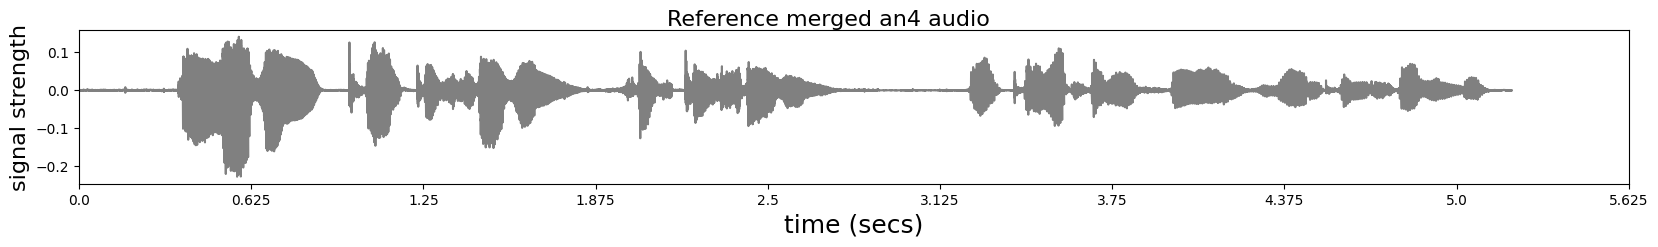

In [ ]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import librosa

sr = 16000
signal, sr = librosa.load(an4_audio,sr=sr)

fig,ax = plt.subplots(1,1)
fig.set_figwidth(20)
fig.set_figheight(2)
plt.plot(np.arange(len(signal)),signal,'gray')
fig.suptitle('Reference merged an4 audio', fontsize=16)
plt.xlabel('time (secs)', fontsize=18)
ax.margins(x=0)
plt.ylabel('signal strength', fontsize=16);
a,_ = plt.xticks();plt.xticks(a,a/sr);

IPython.display.Audio(an4_audio)

## Speaker Diarization using NeMo MSDD Model
---
This code uses a model called Nvidia NeMo MSDD (Multi-scale Diarization Decoder) to perform speaker diarization on an audio signal. Speaker diarization is the process of separating an audio signal into different segments based on who is speaking at any given time.

In [ ]:
# Initialize NeMo MSDD diarization model
msdd_model = NeuralDiarizer(cfg=create_config(temp_path)).to("cuda")
msdd_model.diarize()

#del msdd_model
torch.cuda.empty_cache()

[NeMo I 2024-05-30 00:32:38 msdd_models:1092] Loading pretrained diar_msdd_telephonic model from NGC
[NeMo I 2024-05-30 00:32:38 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 00:32:38 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo
[NeMo I 2024-05-30 00:32:38 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 00:32:39 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: true
    
[NeMo W 2024-05-30 00:32:39 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    emb_dir: null
    sample_rate: 16000
    num_spks: 2
    soft_label_thres: 0.5
    labels: null
    batch_size: 15
    emb_batch_size: 0
    shuffle: false
    
[NeMo W 2024-05-30 00:32:39 modelPT:178] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple

[NeMo I 2024-05-30 00:32:39 features:289] PADDING: 16
[NeMo I 2024-05-30 00:32:39 features:289] PADDING: 16
[NeMo I 2024-05-30 00:32:40 save_restore_connector:249] Model EncDecDiarLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/diar_msdd_telephonic/3c3697a0a46f945574fa407149975a13/diar_msdd_telephonic.nemo.
[NeMo I 2024-05-30 00:32:40 features:289] PADDING: 16
[NeMo I 2024-05-30 00:32:40 clustering_diarizer:127] Loading pretrained vad_multilingual_marblenet model from NGC
[NeMo I 2024-05-30 00:32:40 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 00:32:40 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo
[NeMo I 2024-05-30 00:32:40 common:924] Instantiating model from pre-trained checkpoint


[NeMo W 2024-05-30 00:32:40 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/ami_train_0.63.json,/manifests/freesound_background_train.json,/manifests/freesound_laughter_train.json,/manifests/fisher_2004_background.json,/manifests/fisher_2004_speech_sampled.json,/manifests/google_train_manifest.json,/manifests/icsi_all_0.63.json,/manifests/musan_freesound_train.json,/manifests/musan_music_train.json,/manifests/musan_soundbible_train.json,/manifests/mandarin_train_sample.json,/manifests/german_train_sample.json,/manifests/spanish_train_sample.json,/manifests/french_train_sample.json,/manifests/russian_train_sample.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 256
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: sca

[NeMo I 2024-05-30 00:32:40 features:289] PADDING: 16
[NeMo I 2024-05-30 00:32:41 save_restore_connector:249] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0/vad_multilingual_marblenet/670f425c7f186060b7a7268ba6dfacb2/vad_multilingual_marblenet.nemo.
[NeMo I 2024-05-30 00:32:41 msdd_models:864] Multiscale Weights: [1, 1, 1, 1, 1]
[NeMo I 2024-05-30 00:32:41 msdd_models:865] Clustering Parameters: {
        "oracle_num_speakers": false,
        "max_num_speakers": 8,
        "enhanced_count_thres": 80,
        "max_rp_threshold": 0.25,
        "sparse_search_volume": 30,
        "maj_vote_spk_count": false,
        "chunk_cluster_count": 50,
        "embeddings_per_chunk": 10000
    }
[NeMo I 2024-05-30 00:32:41 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 00:32:41 clustering_diarizer:309] Split long audio file to avoid CUDA memory issue


splitting manifest: 100%|██████████| 1/1 [00:00<00:00, 648.77it/s]

[NeMo I 2024-05-30 00:32:41 classification_models:273] Perform streaming frame-level VAD
[NeMo I 2024-05-30 00:32:41 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 00:32:41 collections:446] Dataset loaded with 1 items, total duration of  0.00 hours.
[NeMo I 2024-05-30 00:32:41 collections:448] # 1 files loaded accounting to # 1 labels



vad: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

[NeMo I 2024-05-30 00:32:41 clustering_diarizer:250] Generating predictions with overlapping input segments


[NeMo I 2024-05-30 00:32:41 clustering_diarizer:262] Converting frame level prediction to speech/no-speech segment in start and end times format.


creating speech segments: 100%|██████████| 1/1 [00:00<00:00, 27.20it/s]

[NeMo I 2024-05-30 00:32:41 clustering_diarizer:287] Subsegmentation for embedding extraction: scale0, /content/temp_outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2024-05-30 00:32:41 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 00:32:41 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 00:32:41 collections:446] Dataset loaded with 5 items, total duration of  0.00 hours.
[NeMo I 2024-05-30 00:32:41 collections:448] # 5 files loaded accounting to # 1 labels



[1/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]

[NeMo I 2024-05-30 00:32:41 clustering_diarizer:389] Saved embedding files to /content/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 00:32:41 clustering_diarizer:287] Subsegmentation for embedding extraction: scale1, /content/temp_outputs/speaker_outputs/subsegments_scale1.json
[NeMo I 2024-05-30 00:32:41 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 00:32:42 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 00:32:42 collections:446] Dataset loaded with 7 items, total duration of  0.00 hours.
[NeMo I 2024-05-30 00:32:42 collections:448] # 7 files loaded accounting to # 1 labels



[2/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 22.20it/s]

[NeMo I 2024-05-30 00:32:42 clustering_diarizer:389] Saved embedding files to /content/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 00:32:42 clustering_diarizer:287] Subsegmentation for embedding extraction: scale2, /content/temp_outputs/speaker_outputs/subsegments_scale2.json
[NeMo I 2024-05-30 00:32:42 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 00:32:42 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 00:32:42 collections:446] Dataset loaded with 8 items, total duration of  0.00 hours.
[NeMo I 2024-05-30 00:32:42 collections:448] # 8 files loaded accounting to # 1 labels



[3/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 20.82it/s]

[NeMo I 2024-05-30 00:32:42 clustering_diarizer:389] Saved embedding files to /content/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 00:32:42 clustering_diarizer:287] Subsegmentation for embedding extraction: scale3, /content/temp_outputs/speaker_outputs/subsegments_scale3.json
[NeMo I 2024-05-30 00:32:42 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 00:32:42 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 00:32:42 collections:446] Dataset loaded with 11 items, total duration of  0.00 hours.
[NeMo I 2024-05-30 00:32:42 collections:448] # 11 files loaded accounting to # 1 labels



[4/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s]

[NeMo I 2024-05-30 00:32:42 clustering_diarizer:389] Saved embedding files to /content/temp_outputs/speaker_outputs/embeddings
[NeMo I 2024-05-30 00:32:42 clustering_diarizer:287] Subsegmentation for embedding extraction: scale4, /content/temp_outputs/speaker_outputs/subsegments_scale4.json
[NeMo I 2024-05-30 00:32:42 clustering_diarizer:343] Extracting embeddings for Diarization
[NeMo I 2024-05-30 00:32:42 collections:445] Filtered duration for loading collection is  0.00 hours.
[NeMo I 2024-05-30 00:32:42 collections:446] Dataset loaded with 17 items, total duration of  0.00 hours.
[NeMo I 2024-05-30 00:32:42 collections:448] # 17 files loaded accounting to # 1 labels



[5/5] extract embeddings: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]

[NeMo I 2024-05-30 00:32:42 clustering_diarizer:389] Saved embedding files to /content/temp_outputs/speaker_outputs/embeddings



clustering: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

[NeMo I 2024-05-30 00:32:42 clustering_diarizer:464] Outputs are saved in /content/temp_outputs directory



[NeMo W 2024-05-30 00:32:42 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 00:32:42 msdd_models:960] Loading embedding pickle file of scale:0 at /content/temp_outputs/speaker_outputs/embeddings/subsegments_scale0_embeddings.pkl
[NeMo I 2024-05-30 00:32:42 msdd_models:960] Loading embedding pickle file of scale:1 at /content/temp_outputs/speaker_outputs/embeddings/subsegments_scale1_embeddings.pkl
[NeMo I 2024-05-30 00:32:42 msdd_models:960] Loading embedding pickle file of scale:2 at /content/temp_outputs/speaker_outputs/embeddings/subsegments_scale2_embeddings.pkl
[NeMo I 2024-05-30 00:32:42 msdd_models:960] Loading embedding pickle file of scale:3 at /content/temp_outputs/speaker_outputs/embeddings/subsegments_scale3_embeddings.pkl
[NeMo I 2024-05-30 00:32:42 msdd_models:960] Loading embedding pickle file of scale:4 at /content/temp_outputs/speaker_outputs/embeddings/subsegments_scale4_embeddings.pkl
[NeMo I 2024-05-30 00:32:42 msdd_models:938] Loading cluster label file from /content/temp_outputs/speaker_outputs/subsegments_scale4_cluste

100%|██████████| 1/1 [00:00<00:00, 24.71it/s]

[NeMo I 2024-05-30 00:32:42 msdd_models:1403]      [Threshold: 0.7000] [use_clus_as_main=False] [diar_window=50]
[NeMo I 2024-05-30 00:32:42 speaker_utils:93] Number of files to diarize: 1
[NeMo I 2024-05-30 00:32:42 speaker_utils:93] Number of files to diarize: 1



[NeMo W 2024-05-30 00:32:42 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 00:32:42 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 00:32:42 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 00:32:42 speaker_utils:93] Number of files to diarize: 1


[NeMo W 2024-05-30 00:32:42 der:185] Check if each ground truth RTTMs were present in the provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2024-05-30 00:32:42 msdd_models:1431]   
    


In [ ]:
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.core import Annotation

metric = DiarizationErrorRate()
reference = Annotation('an4_diarize_test.rttm')
hypothesis = Annotation('mono_file.rttm')

value = metric(reference, hypothesis)
print(value)

0.0


## Mapping Speakers to Sentences According to Timestamps

In [ ]:
# Reading timestamps <> Speaker Labels mapping

speaker_ts = []

with open(os.path.join(temp_path, "pred_rttms", "mono_file.rttm"), "r") as f:
    lines = f.readlines()
    print("Lines: ", lines)
    for line in lines:
        line_list = line.split(" ")
        s = int(float(line_list[5]) * 1000)
        e = s + int(float(line_list[8]) * 1000)
        speaker_ts.append([s, e, int(line_list[11].split("_")[-1])])

wsm = get_words_speaker_mapping(word_timestamps, speaker_ts, "start")

Lines:  ['SPEAKER mono_file 1   0.300   2.540 <NA> <NA> speaker_0 <NA> <NA>\n', 'SPEAKER mono_file 1   3.180   1.970 <NA> <NA> speaker_1 <NA> <NA>\n']


## Realligning Speech segments using Punctuation
---

This code provides a method for disambiguating speaker labels in cases where a sentence is split between two different speakers. It uses punctuation markings to determine the dominant speaker for each sentence in the transcription.

```
Speaker A: It's got to come from somewhere else. Yeah, that one's also fun because you know the lows are
Speaker B: going to suck, right? So it's actually it hits you on both sides.
```

For example, if a sentence is split between two speakers, the code takes the mode of speaker labels for each word in the sentence, and uses that speaker label for the whole sentence. This can help to improve the accuracy of speaker diarization, especially in cases where the Whisper model may not take fine utterances like "hmm" and "yeah" into account, but the Diarization Model (Nemo) may include them, leading to inconsistent results.

The code also handles cases where one speaker is giving a monologue while other speakers are making occasional comments in the background. It ignores the comments and assigns the entire monologue to the speaker who is speaking the majority of the time. This provides a robust and reliable method for realigning speech segments to their respective speakers based on punctuation in the transcription.

In [ ]:
if language in punct_model_langs:
    # restoring punctuation in the transcript to help realign the sentences
    punct_model = PunctuationModel(model="kredor/punctuate-all")

    words_list = list(map(lambda x: x["word"], wsm))

    labled_words = punct_model.predict(words_list,chunk_size=230)

    ending_puncts = ".?!"
    model_puncts = ".,;:!?"

    # We don't want to punctuate U.S.A. with a period. Right?
    is_acronym = lambda x: re.fullmatch(r"\b(?:[a-zA-Z]\.){2,}", x)

    for word_dict, labeled_tuple in zip(wsm, labled_words):
        word = word_dict["word"]
        if (
            word
            and labeled_tuple[1] in ending_puncts
            and (word[-1] not in model_puncts or is_acronym(word))
        ):
            word += labeled_tuple[1]
            if word.endswith(".."):
                word = word.rstrip(".")
            word_dict["word"] = word

else:
    logging.warning(
        f"Punctuation restoration is not available for {language} language. Using the original punctuation."
    )

wsm = get_realigned_ws_mapping_with_punctuation(wsm)
ssm = get_sentences_speaker_mapping(wsm, speaker_ts)

## Cleanup and Exporing the results

In [ ]:
# Take the number between the RTTM and this other thing

In [ ]:
with open(f"{os.path.splitext(audio_path)[0]}.txt", "w", encoding="utf-8-sig") as f:
    get_speaker_aware_transcript(ssm, f)

with open(f"{os.path.splitext(audio_path)[0]}.srt", "w", encoding="utf-8-sig") as srt:
    write_srt(ssm, srt)

#cleanup(temp_path)

## Measure DER using PyAnnote Library

In [ ]:
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.core import Annotation

metric = DiarizationErrorRate()
reference = Annotation()
hypothesis = Annotation()

value = metric(reference, hypothesis)
print(value)